In [ ]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Experimental data analysis

In [ ]:
with open('colors_dict.pkl', 'rb') as f:
    color_dict = pickle.load(f)

In [ ]:
color_order = ['blue', 'orange', 'yellow', 'purple', 'green']
colors = [color_dict[k]['medium'] for k in color_order]
colors_dark = [color_dict[k]['dark'] for k in color_order]

import matplotlib.colors as clr
cmap = clr.LinearSegmentedColormap.from_list('custom cm', [colors_dark[0], color_dict['yellow']['light']], N=256)

linewidth = 2
alpha_grid = 0.2

# Analysis functions

In [ ]:
import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

# Dataset WT

## Load the data

We start our analysis by loading the trajectories with their predictions. The data is in pixel and frame units, with every pixel corresponding to 109.67nm acquired at 30Hz.

In [ ]:
data_path = Path('../../../hdd/seg_data/data_carlo')
df_wt = pd.read_csv(data_path/'inference_WT_noise.csv', header=None)
# df_wt = pd.read_csv('data/inference_wt_noise_new.csv', header = None)

In [ ]:
correction = np.log10(30*0.10967**2)

In [ ]:
# data_path = Path('../../../hdd/seg_data/data_juan')
# df_wt = pd.read_csv(data_path/'Mutants_DEF_pred_WT.csv', header='infer')
# df_wt = df_wt.rename(columns={'index': 'traj_idx', 'pred_D': 'D', 'pred_D_10x': 'D_10x', 'pred_D_100x': 'D_100x', 'pred_alpha': 'alpha'})

In [ ]:
df_wt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,768.699381,28.824000,0.037044,0.0,0.0,7.0,1.0,1.0,0.000000,2.0,0.0,1.0,0.0,-3.008628,-0.009023,0.361828
1,768.827574,28.866126,0.041805,0.0,0.0,7.0,2.0,1.0,0.030001,2.0,0.0,1.0,0.0,-3.008745,-0.023551,0.387720
2,768.764853,28.867053,0.036744,0.0,0.0,7.0,3.0,1.0,0.060001,2.0,0.0,1.0,0.0,-3.010670,-0.069577,0.370569
3,768.789332,28.986935,0.027895,0.0,0.0,7.0,4.0,1.0,0.090002,2.0,0.0,1.0,0.0,-3.009328,-0.031990,0.387756
4,768.697807,28.890368,0.029874,0.0,0.0,7.0,5.0,1.0,0.120003,2.0,0.0,1.0,0.0,-3.009745,-0.043070,0.375328


In the dataframe, column 12 contains the trajectory index, and the columns 13, 14 and 15 have the predictions for the diffusion coefficient $D$, $D$ on rescaled trajectories by a factor of $+2$ in log scale ($D + 4$) and $\alpha$, respectively. To make the code more readable, let's rename the important columns.

In [ ]:
df_wt = df_wt.rename(columns={0: 'x', 1: 'y', 12: 'traj_idx', 13: 'D', 14: 'D_100x', 15: 'alpha'})

Since the diffusion coefficient predictions did not fit in the output range of our model, we need to combine the original outputs with the predictions in the rescaled trajectories. We take the rescaled prediction on $D$ wherever the original prediction was lower than $-2$, and we correct it by a factor of $-4$.

In [ ]:
threshold, correction = -2, -4
df_wt['D_tfm'] = np.where(df_wt.D >= threshold, df_wt.D, df_wt.D_100x + correction)
# Ds = np.append(df_wt.loc[df_wt[13].values > change][13], df_wt.loc[df_wt[14].values - 4 < change][14] - 4 )

In [ ]:
df_wt.head()

,x,y,2,3,4,5,6,7,8,9,10,11,traj_idx,D,D_100x,alpha,D_tfm
0,768.699381,28.824000,0.037044,0.0,0.0,7.0,1.0,1.0,0.000000,2.0,0.0,1.0,0.0,-3.008628,-0.009023,0.361828,-4.009023
1,768.827574,28.866126,0.041805,0.0,0.0,7.0,2.0,1.0,0.030001,2.0,0.0,1.0,0.0,-3.008745,-0.023551,0.387720,-4.023551
2,768.764853,28.867053,0.036744,0.0,0.0,7.0,3.0,1.0,0.060001,2.0,0.0,1.0,0.0,-3.010670,-0.069577,0.370569,-4.069577
3,768.789332,28.986935,0.027895,0.0,0.0,7.0,4.0,1.0,0.090002,2.0,0.0,1.0,0.0,-3.009328,-0.031990,0.387756,-4.031990
4,768.697807,28.890368,0.029874,0.0,0.0,7.0,5.0,1.0,0.120003,2.0,0.0,1.0,0.0,-3.009745,-0.043070,0.375328,-4.043070


Let's visualize the predictions! We start by looking at a histogram of the diffusion coefficient.

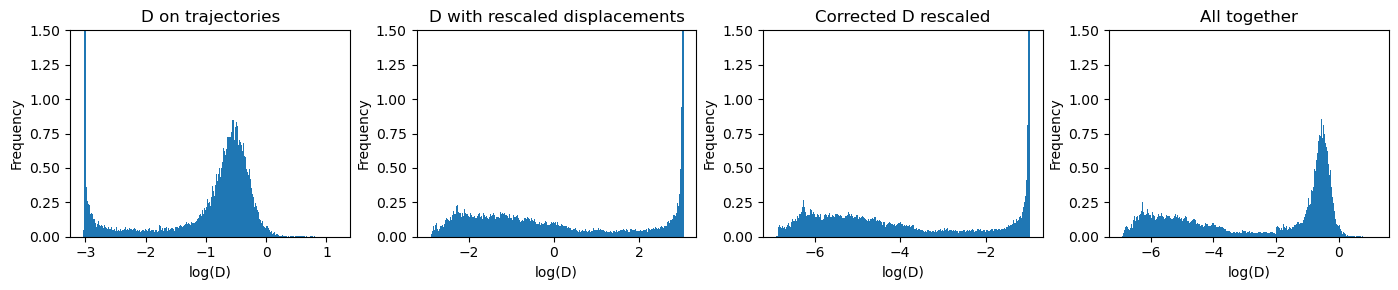

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (14, 3), tight_layout=True)
axs[0].hist(df_wt.D, bins=1000, density=True);
axs[0].set_title('D on trajectories')


axs[1].hist(df_wt.D_100x, bins=1000, density=True);
axs[1].set_title('D with rescaled displacements')


axs[2].hist(df_wt.D_100x - 4, bins=1000, density=True);
axs[2].set_title('Corrected D rescaled')


axs[3].hist(df_wt.D_tfm, bins = 1000, density=True);
axs[3].set_title('All together')

plt.setp(axs, xlabel='log(D)', ylabel='Frequency', ylim=(0, 1.5));

Let's do the same for the anomalous exponent.

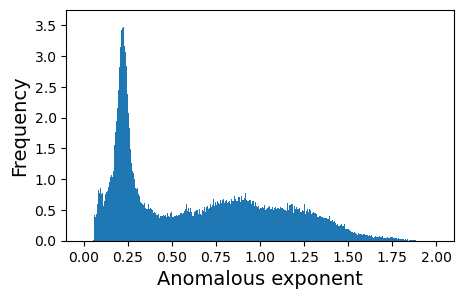

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(df_wt.alpha, bins=np.linspace(0,2,1000), density=True)
plt.xlabel('Anomalous exponent', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

The predictions look neat. We see two distinct modes in $D$ and two more for $\alpha$ (maybe 3?). Let's combine both predictions together.

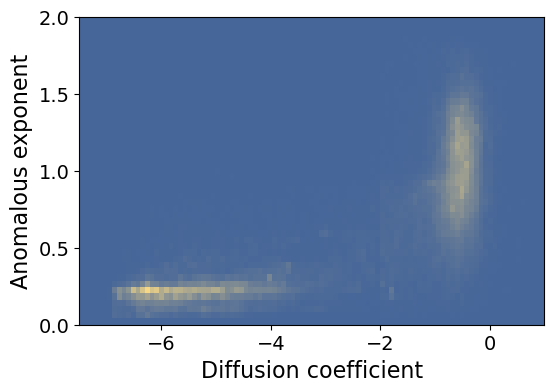

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(df_wt.D_tfm, df_wt.alpha, bins=[np.linspace(-7.5,1,100), np.linspace(0,2,50)],
           density=True, cmap=cmap)

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

We observe, at least, two clear differentiated states: low $D$ and low $\alpha$, high $D$ and high $\alpha$.

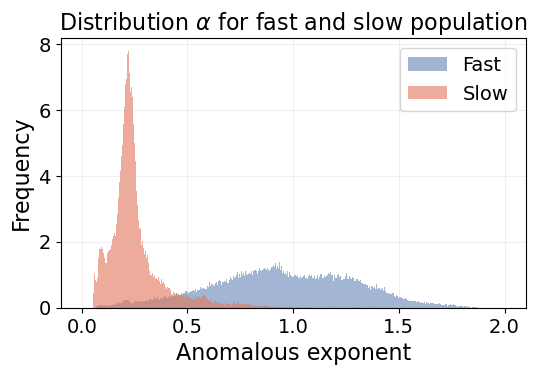

In [ ]:
plt.figure(figsize=(6, 3.5))
plt.hist(df_wt[df_wt.D_tfm > -2].alpha, bins = np.linspace(0,2,1000), label='Fast',
         density=True, color=colors[0], alpha=0.6)
plt.hist(df_wt[df_wt.D_tfm < -2].alpha, bins = np.linspace(0,2,1000), label='Slow',
         density=True, color=colors[1], alpha=0.6)

plt.grid(alpha=alpha_grid)
plt.legend(fontsize=14)
plt.xlabel('Anomalous exponent', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title(r'Distribution $\alpha$ for fast and slow population', fontsize=16)
plt.tick_params(labelsize=14)

## Clustering analysis
Let's dive deeper into the analysis! In order to properly define the different diffusive states, we will perform a clustering analysis.

In [ ]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

### Point-wise clustering
We start by performing a clustering analysis directly on the data points, i.e., the predictions at every time step.

First, we will perform a simple test to find out the most likely amount of clusters.

In [ ]:
scaler = StandardScaler()
x = np.stack(((df_wt.D_tfm + 7)/4, df_wt.alpha), axis=-1)
x = scaler.fit_transform(x)

sse = []
n_clusters = np.arange(2, 11)
for n in tqdm(n_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

  0%|          | 0/9 [00:00<?, ?it/s]

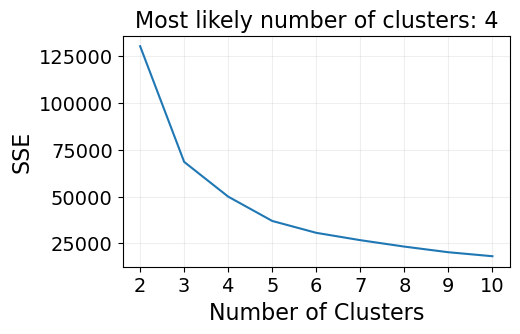

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(n_clusters, sse)
plt.xticks(n_clusters)
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("SSE", fontsize=16)
plt.grid(alpha=alpha_grid)
plt.tick_params(labelsize=14)
kl = KneeLocator(n_clusters, sse, curve="convex", direction="decreasing")
plt.title(f"Most likely number of clusters: {kl.elbow}", fontsize=16);

It seems that, rather than just two states, there are four! Let's see these clusters.

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=10, max_iter=300, random_state=42)
kmeans.fit(x)
df_wt['cluster_point'] = kmeans.predict(x)

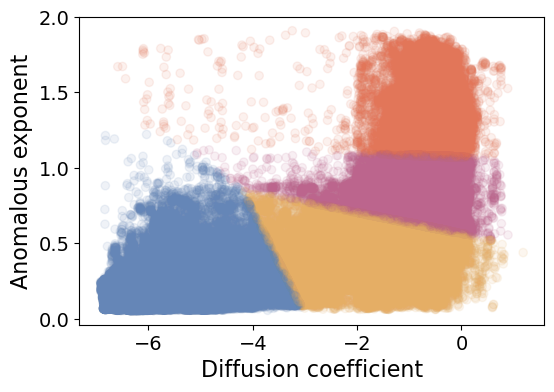

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df_wt.D_tfm, df_wt.alpha, alpha=0.1, c=df_wt.cluster_point,
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

Let's see what we obtain with a Gaussian Mixture model.

In [ ]:
gm = GaussianMixture(n_components=4, n_init=10, random_state=42)
gm.fit(x)
cluster_gm = gm.predict(x)

In [ ]:
map_clusters = {0: 1, 1: 2, 2: 3, 3: 0}
gm_colors = np.array([map_clusters[c] for c in cluster_gm]) # This is to preserve the colors

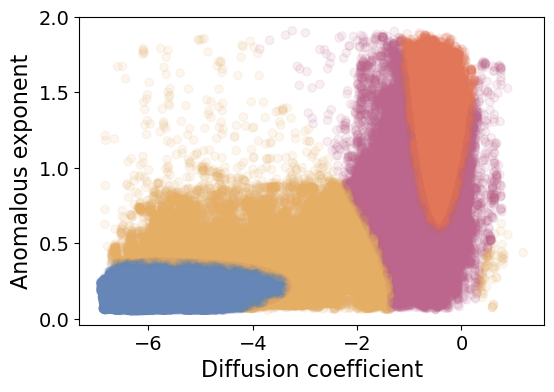

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df_wt.D_tfm, df_wt.alpha, c=gm_colors, alpha=0.1,
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

From the cluster labeling, we can see that there are two well pronounced components and two intermediate ones. Let us look at the resulting distributions by drawing the ellipses corresponding to each mode.

In [ ]:
def make_ellipses(gmm, ax):
    """Adapted from 
    https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html"""
    import matplotlib as mpl
    for n in range(gmm.n_components):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1])*gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0]/np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180*angle/np.pi  # convert to degrees
        v = 2.0*np.sqrt(2.0)*np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1], 180+angle, color=colors[map_clusters[n]])
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.7)
        ax.add_artist(ell)
        # ax.set_aspect("equal", "datalim")

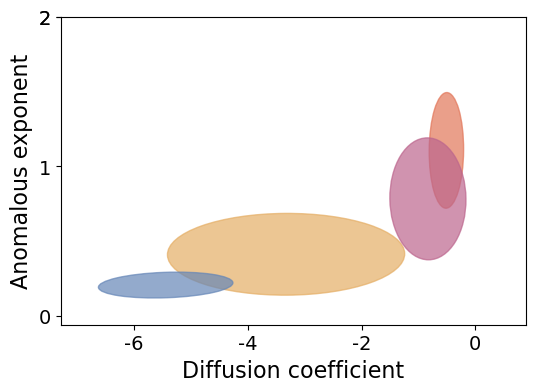

In [ ]:
xlim, ylim = [-2, 1.5], [-1.6, 3]

x_plt = np.stack(([-6, -4, -2, 0], [0, 1, 2, 2])).T.astype(float)
x_tfm = x_plt.copy()
x_tfm[:, 0] = (x_tfm[:, 0] + 7)/4
x_tfm = scaler.transform(x_tfm)


fig, ax = plt.subplots(figsize=(6, 4))
# ax.scatter(x[:5000, 0], x[:5000, 1], alpha=0.5)
make_ellipses(gm, ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks(x_tfm[:, 0], [f'{l:.0f}' for l in x_plt[:, 0]])
ax.set_yticks(x_tfm[:, 1], [f'{l:.0f}' for l in x_plt[:, 1]])
ax.tick_params(labelsize=14)
ax.set_xlabel("Diffusion coefficient", fontsize=16)
ax.set_ylabel("Anomalous exponent", fontsize=16);

There are four differentiated modes: what seem to be a strongly traped one, a confined one, a normal(-ish) diffusion mode, and a super-diffusive mode. In order to obtain a better understanding of the process, we will perform a trajectory segmentation according to the obtained clusters and study the properties of each population.  

#### Segmentation by clusters
We will take the states provided by the k-means clustering to see whether there are significant differences between those.

In [ ]:
def find_segments_by_cluster(pred_label, pred_d, pred_alpha, traj, pen=1, **kwargs):    
    def _majority_vote(x):
        values, counts = np.unique(x, return_counts=True)
        return np.random.choice(values[counts == counts.max()]) # break ties randomly
    
    def _find_change_points(x):
        cps = ((x[:-1] - x[1:]) != 0).nonzero()[0] + 1
        return np.concatenate(([0], cps, [len(x)]))
    
    alg = rpt.KernelCPD(**kwargs).fit(pred_label)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, seg_labels = [], []
    Ds, alphas = [], []
    angles, var = [], []
    
    labels = np.ones_like(pred_label)
    for i, j in zip(cps[:-1], cps[1:]):
        labels[i:j] *= _majority_vote(pred_label[i:j])
    cps = _find_change_points(labels) # Check again without prediction noise
            
    for i, j in zip(cps[:-1], cps[1:]):
        seg_labels.append(labels[i])
        segment = traj[:, i:j]
        alpha_seg = pred_alpha[i:j].mean()
        D_seg = pred_d[i:j].mean()

        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            var.append(segment.var(1).mean())
        segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)

    res_time = cps[1:] - cps[:-1]
    res_time = res_time[1:-1]
    Ds_clean = Ds[1:-1]
    alphas_clean = alphas[1:-1]

    return (labels, seg_labels, segments, Ds, alphas, Ds_clean,
            alphas_clean, angles, res_time, var)

In [ ]:
Ds, preds, trajs, alphas, labels = [], [], [], [], []
seg_ds, seg_alphas, seg_vars, seg_angs = [], [], [], []
seg_ds_clean, seg_alphas_clean, seg_res, seg_vars = [], [], [], []
angle_0, angle_1, angle_2, angle_3 = [], [], [], []

for idx in tqdm(np.unique(df_wt.traj_idx)):
    mask = df_wt.traj_idx == idx
    pred_d = df_wt.loc[mask, 'D_tfm'].values
    pred_alpha = df_wt.loc[mask, 'alpha'].values
    cluster_label = df_wt.loc[mask, 'cluster_point'].values
    x, y = df_wt[mask].x.values, df_wt[mask].y.values
    traj = np.array([x-x[0], y-y[0]])

    out = find_segments_by_cluster(cluster_label, pred_d, pred_alpha, traj, min_size=5)
    new_label, seg_labels, segments, d_seg, a_seg, ds_clean, as_clean, angs, res_time, var = out
    
    seg_ds.append(d_seg)
    seg_alphas.append(a_seg)
    seg_res.append(res_time) 
    seg_vars.append(var)
    seg_angs.append(angs)
    seg_ds_clean.append(ds_clean)
    seg_alphas_clean.append(as_clean)
    df_wt.loc[mask, 'cluster_segment'] = new_label
    
    for l, a  in zip(seg_labels, angs):
        if l == 0:   angle_0.append(a)
        elif l == 1: angle_1.append(a)
        elif l == 2: angle_2.append(a)
        elif l == 3: angle_3.append(a)
    
    preds.append(pred_d)
    Ds.append(np.power(10, pred_d))
    alphas.append(pred_alpha)
    labels.append(seg_labels)
    trajs.append(segments)

  0%|          | 0/4734 [00:00<?, ?it/s]

In [ ]:
seg_alphas, seg_ds = np.concatenate(seg_alphas), np.concatenate(seg_ds)
seg_alphas_clean = np.concatenate(seg_alphas_clean)
seg_ds_clean = np.concatenate(seg_ds_clean)
angle_0, angle_1 = np.concatenate(angle_0), np.concatenate(angle_1)
angle_2, angle_3 = np.concatenate(angle_2), np.concatenate(angle_3)

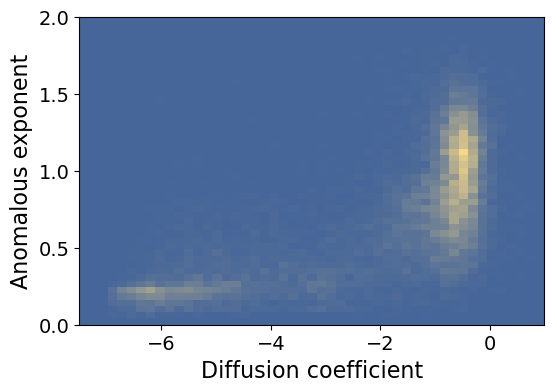

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(seg_ds, seg_alphas, bins=[np.linspace(-7.5,1,50), np.linspace(0,2,50)], density=True, cmap=cmap);

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

In [ ]:
x = np.stack(((seg_ds + 7)/4, seg_alphas), axis=-1)
x_clean = np.stack(((seg_ds_clean + 7)/4, seg_alphas_clean), axis=-1)

x = scaler.transform(x)
x_clean = scaler.transform(x_clean)

labels = kmeans.predict(x)
labels_clean = kmeans.predict(x_clean)

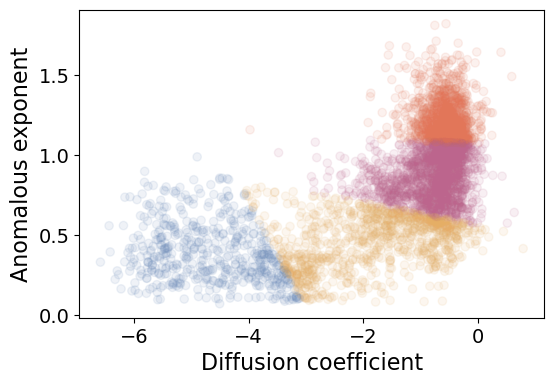

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(seg_ds_clean, seg_alphas_clean, alpha=0.1, c=labels_clean,
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4));

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

#### Angle distribution by clusters

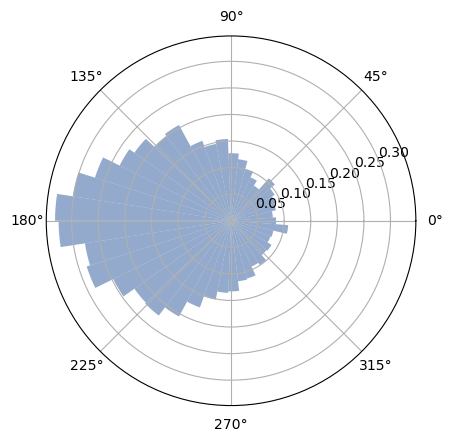

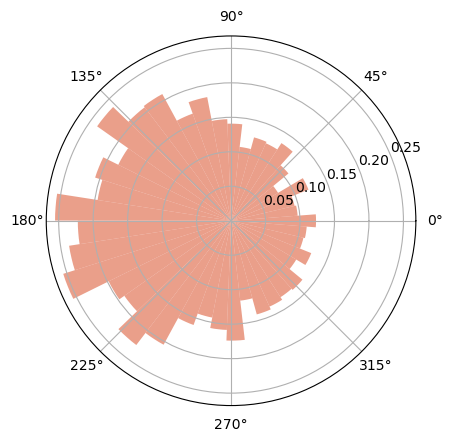

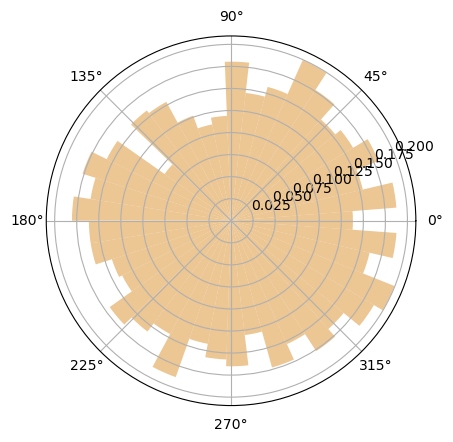

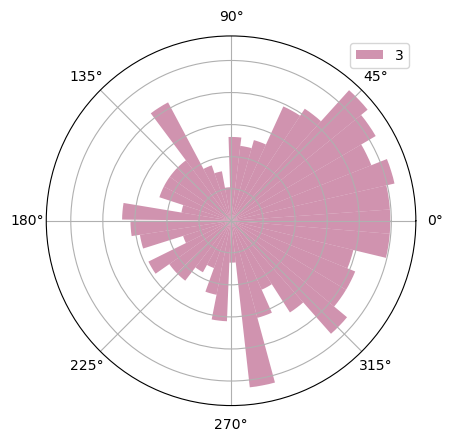

In [ ]:
for i, ang in enumerate([angle_0, angle_1, angle_2, angle_3]):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.hist(2*np.pi*np.array(ang)/360, bins=41, density=1, label=i, color=colors[i], alpha=0.7)
ax.legend()
plt.setp(ax, yticklabels = []);

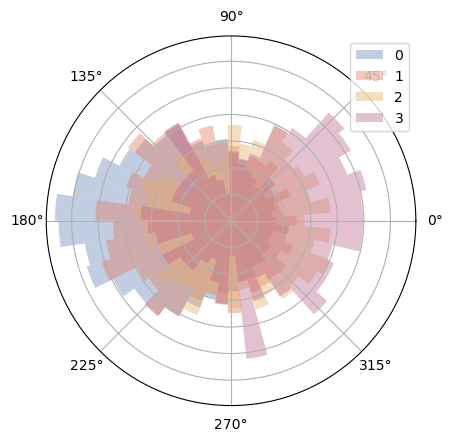

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for i, ang in enumerate([angle_0, angle_1, angle_2, angle_3]):
    ax.hist(2*np.pi*np.array(ang)/360, bins=41, density=1, label=i, color=colors[i], alpha=0.4)
ax.legend()
plt.setp(ax, yticklabels = []);

Let's see the displacement distribution for the directed motion. We start by finding the segment indices that contain a directed segment.

In [ ]:
traj_idx_dir = np.unique(df_wt[df_wt.cluster_segment == 1].traj_idx).astype(int)

In [ ]:
displacements_directed = []
displacements_very_directed = []
angle_threshold = 10
for traj_idx in traj_idx_dir:
    for seg_idx, seg_label in enumerate(labels[traj_idx]):
        if seg_label != 1: continue
        segment = trajs[traj_idx][seg_idx]
        displacements = np.sqrt(np.sum(np.diff(segment, axis=-1)**2, axis=0))
        displacements_directed.append(displacements)
        angles = np.array(seg_angs[traj_idx][seg_idx])
        angle_mask = np.abs(angles) < angle_threshold
        displ_mask = [angle_mask[i-1:i+1].any() for i in range(1, len(angle_mask))]
        displ_mask = [angle_mask[0]] + displ_mask + [angle_mask[-1]]
        displacements_very_directed.append(displacements[displ_mask])
displacements_directed = np.concatenate(displacements_directed)
displacements_very_directed = np.concatenate(displacements_very_directed)

In [ ]:
displ_counts, displ_edges = np.histogram(displacements_directed, bins=51, density=True)
displ_dir_counts, displ_dir_edges = np.histogram(displacements_very_directed, bins=51, density=True)

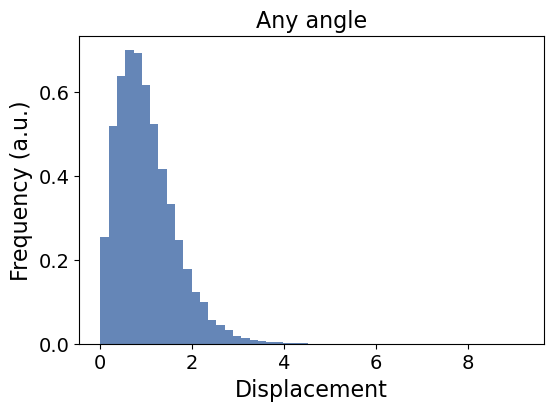

In [ ]:
bin_size = displ_edges[1] - displ_edges[0]
displ_x = displ_edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(displ_x, displ_counts, width=bin_size, color=colors[0])
plt.tick_params(labelsize=14)
plt.xlabel("Displacement", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title("Any angle", fontsize=16);

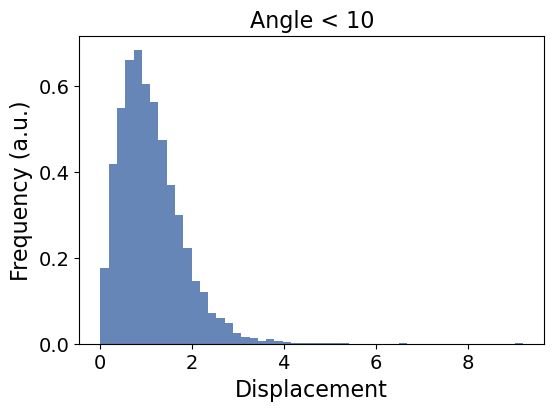

In [ ]:
bin_size = displ_dir_edges[1] - displ_dir_edges[0]
displ_x = displ_dir_edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(displ_x, displ_dir_counts, width=bin_size, color=colors[0])
plt.tick_params(labelsize=14)
plt.xlabel("Displacement", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title(f"Angle < {angle_threshold}", fontsize=16);

In [ ]:
displacements_directed.mean(), displacements_very_directed.mean()

(1.0074734978214286, 1.1134338284189396)

### Segment-wise clustering

We perform a similar analysis doing a pre-segmentation prior to the clustering analysis.

#### Trajectory segmentation
More precisely, we fit the diffusion coefficient predictions by a set of constant segments. This heavily reduces the amount of outlayer points.

In [ ]:
def find_segments(pred_d, pred_alpha, traj, pen=1, **kwargs):
    pred = np.stack((pred_d , pred_alpha), axis=-1)
#     alg = rpt.KernelCPD(**kwargs).fit(pred_d) # Only changes in D
    alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments = []
    Ds, alphas = [], []
    angles, var = [], []
            
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        alpha_seg, D_seg = pred_alpha[i:j].mean(), pred_d[i:j].mean()

        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            var.append(segment.var(1).mean())
            segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)

    res_time = cps[1:] - cps[:-1]
    res_time = res_time[1:-1]
    alphas_clean, Ds_clean = alphas[1:-1], Ds[1:-1]

    return segments, Ds, alphas, Ds_clean, alphas_clean, angles, res_time, var

Let's analyse our trajectories.

In [ ]:
Ds, preds, trajs, alphas = [], [], [], []
seg_ds, seg_alphas, seg_vars, seg_angs = [], [], [], []
seg_ds_clean, seg_alphas_clean, seg_res, seg_vars = [], [], [], []

for idx in tqdm(np.unique(df_wt.traj_idx)):
    mask = df_wt.traj_idx == idx
    pred_d = df_wt.loc[mask, 'D_tfm'].values
    pred_alpha = df_wt.loc[mask, 'alpha'].values
    x, y = df_wt[mask].x.values, df_wt[mask].y.values
    traj = np.array([x-x[0], y-y[0]])

    out = find_segments(pred_d, pred_alpha, traj, min_size=5, pen=0.1)
    segments, d_seg, a_seg, ds_clean, as_clean, angs, res_time, var = out
    
    seg_ds.append(d_seg)
    seg_alphas.append(a_seg)
    seg_res.append(res_time) 
    seg_vars.append(var)
    seg_angs.append(angs)
    seg_ds_clean.append(ds_clean)
    seg_alphas_clean.append(as_clean)
    preds.append(pred_d)
    Ds.append(np.power(10, pred_d))
    alphas.append(pred_alpha)
    trajs.append(segments)

  0%|          | 0/4734 [00:00<?, ?it/s]

In [ ]:
seg_alphas, seg_ds = np.concatenate(seg_alphas), np.concatenate(seg_ds)
seg_alphas_clean = np.concatenate(seg_alphas_clean)
seg_ds_clean = np.concatenate(seg_ds_clean)

Now we can look at the segment distribution of $\alpha$ vs $D$ and we see there are much less outlayers than in the previous case. 

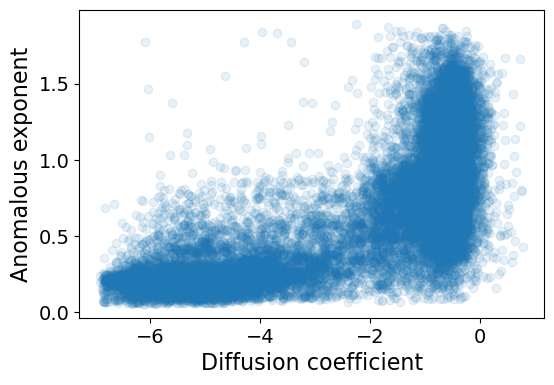

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(seg_ds, seg_alphas, alpha=0.1)

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

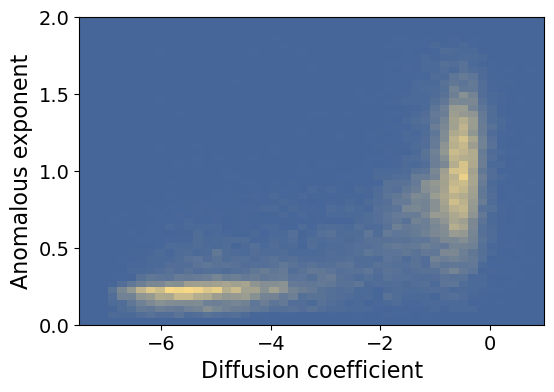

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(seg_ds, seg_alphas, bins=[np.linspace(-7.5,1,50), np.linspace(0,2,50)], density=True, cmap=cmap);

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

#### Clustering

Let's see how many clusters we have and where they lie.

In [ ]:
scaler = StandardScaler()
x = np.stack(((seg_ds + 7)/4, seg_alphas), axis=-1)
x = scaler.fit_transform(x)

sse = []
n_clusters = np.arange(2, 11)
for n in tqdm(n_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

  0%|          | 0/9 [00:00<?, ?it/s]

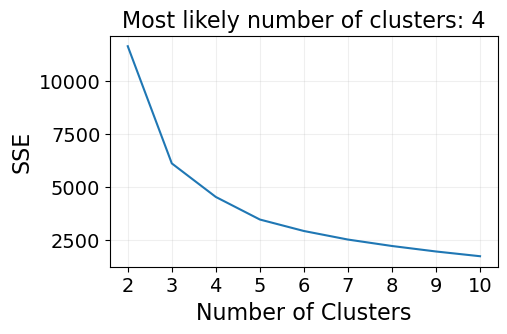

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(n_clusters, sse)
plt.xticks(n_clusters)
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("SSE", fontsize=16)
plt.grid(alpha=alpha_grid)
plt.tick_params(labelsize=14)
kl = KneeLocator(n_clusters, sse, curve="convex", direction="decreasing")
plt.title(f"Most likely number of clusters: {kl.elbow}", fontsize=16);

We find again that the most likely number of clusters is 4!! Let's train a clustering algorithm to detect them and look at the population distributions.

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=10, max_iter=300, random_state=42)
kmeans.fit(x)
seg_labels = kmeans.predict(x)

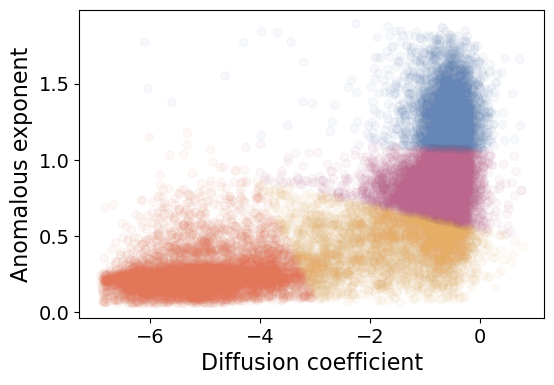

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(seg_ds, seg_alphas, c=seg_labels, alpha=0.05, 
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

In [ ]:
gm = GaussianMixture(n_components=4, n_init=10, random_state=42)
gm.fit(x)
cluster_gm = gm.predict(x)

In [ ]:
# map_clusters = {0: 1, 1: 0, 2: 2, 3: 3}
map_clusters = {0: 0, 1: 1, 2: 3, 3: 2}
gm_colors = np.array([map_clusters[c] for c in cluster_gm]) # This is to preserve the colors

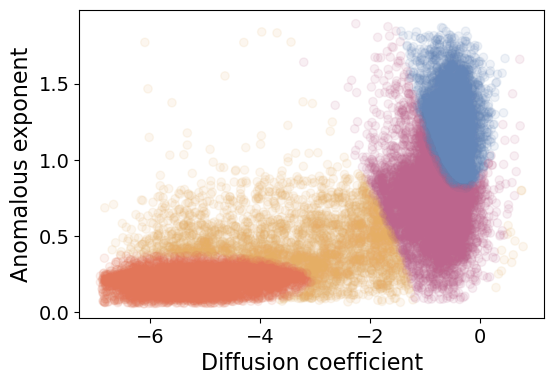

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(seg_ds, seg_alphas, c=gm_colors, alpha=0.1,
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16)
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

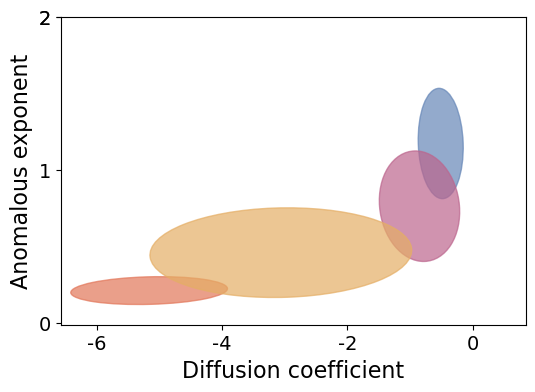

In [ ]:
xlim, ylim = [-2, 1.5], [-1.6, 3]

x_plt = np.stack(([-6, -4, -2, 0], [0, 1, 2, 2])).T.astype(float)
x_tfm = x_plt.copy()
x_tfm[:, 0] = (x_tfm[:, 0] + 7)/4
x_tfm = scaler.transform(x_tfm)


fig, ax = plt.subplots(figsize=(6, 4))
# ax.scatter(x[:5000, 0], x[:5000, 1], alpha=0.5)
make_ellipses(gm, ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks(x_tfm[:, 0], [f'{l:.0f}' for l in x_plt[:, 0]])
ax.set_yticks(x_tfm[:, 1], [f'{l:.0f}' for l in x_plt[:, 1]])
ax.tick_params(labelsize=14)
ax.set_xlabel("Diffusion coefficient", fontsize=16)
ax.set_ylabel("Anomalous exponent", fontsize=16);

#### Angle distribution by clusters

Now that we have the clusters, let's look at the angle distribution for each population.

In [ ]:
angle_0, angle_1, angle_2, angle_3 = [], [], [], []
angs = [a for ang in seg_angs for a in ang]

for l, a  in zip(seg_labels, angs):
    if l == 0:   angle_0.append(a)
    elif l == 1: angle_1.append(a)
    elif l == 2: angle_2.append(a)
    elif l == 3: angle_3.append(a)

In [ ]:
angle_0, angle_1 = np.concatenate(angle_0), np.concatenate(angle_1)
angle_2, angle_3 = np.concatenate(angle_2), np.concatenate(angle_3)

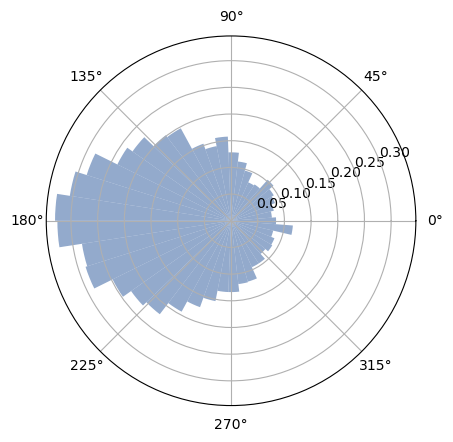

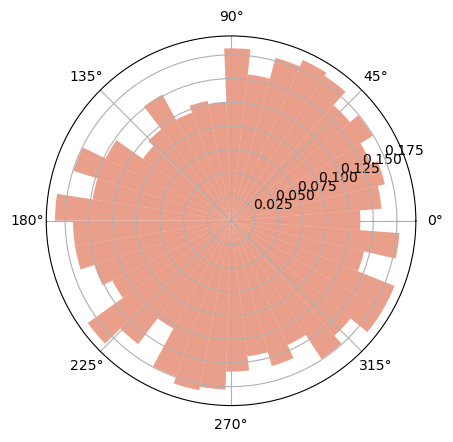

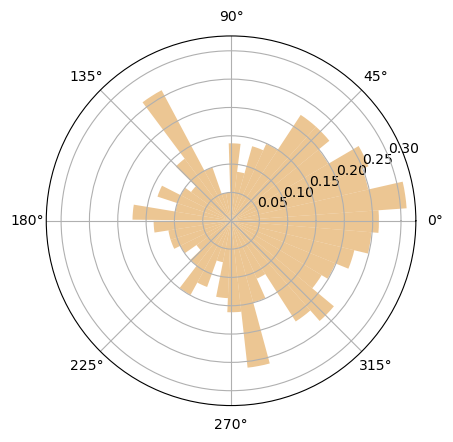

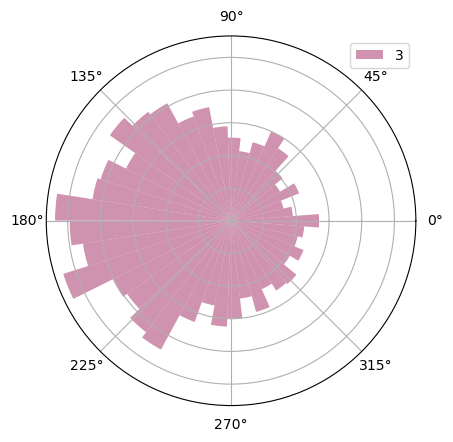

In [ ]:
for i, ang in enumerate([angle_0, angle_1, angle_2, angle_3]):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.hist(2*np.pi*np.array(ang)/360, bins=41, density=1, label=i, color=colors[i], alpha=0.7)
ax.legend()
plt.setp(ax, yticklabels = []);

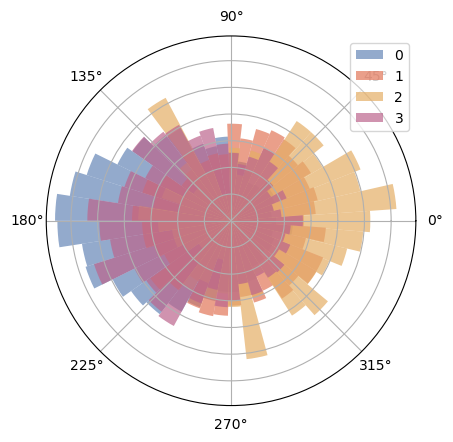

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for i, ang in enumerate([angle_0, angle_1, angle_2, angle_3]):
    ax.hist(2*np.pi*np.array(ang)/360, bins=41, density=1, label=i, color=colors[i], alpha=0.7)
ax.legend()
plt.setp(ax, yticklabels = []);

Let's see the displacement distribution for the directed motion. We start by finding the segment indices that contain a directed segment.

In [ ]:
segments = [s for t in trajs for s in t]
angles = [a for seg_ang in seg_angs for a in seg_ang]

In [ ]:
displacements_directed = []
displacements_very_directed = []
angle_threshold = 5
seg_dir_idx = np.argwhere(seg_labels == 0).squeeze()
for seg_idx in seg_dir_idx:
    segment = segments[seg_idx]
    displacements = np.sqrt(np.sum(np.diff(segment, axis=-1)**2, axis=0))
    displacements_directed.append(displacements)
    angle_mask = np.array(angles[seg_idx]) < angle_threshold
    displ_mask = [angle_mask[i-1:i+1].any() for i in range(1, len(angle_mask))]
    displ_mask = [angle_mask[0]] + displ_mask + [angle_mask[-1]]
    displacements_very_directed.append(displacements[displ_mask])
    
displacements_directed = np.concatenate(displacements_directed)
displacements_very_directed = np.concatenate(displacements_very_directed)

In [ ]:
displ_counts, displ_edges = np.histogram(displacements_directed, bins=np.linspace(0, 5, 51), density=True)
displ_dir_counts, displ_dir_edges = np.histogram(displacements_very_directed, bins=np.linspace(0, 5, 51), density=True)

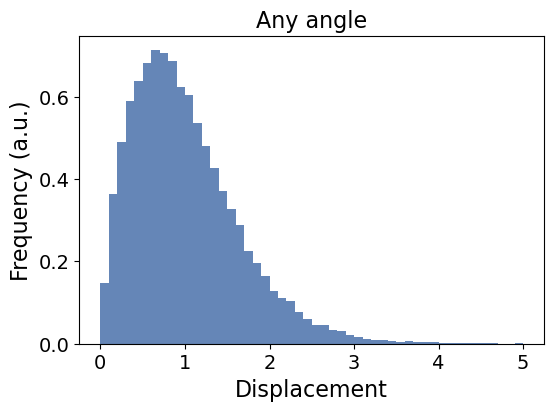

In [ ]:
bin_size = displ_edges[1] - displ_edges[0]
displ_x = displ_edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(displ_x, displ_counts, width=bin_size, color=colors[0])
plt.tick_params(labelsize=14)
plt.xlabel("Displacement", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title("Any angle", fontsize=16);

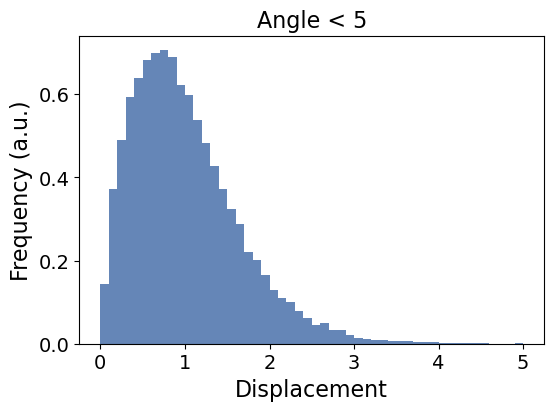

In [ ]:
bin_size = displ_dir_edges[1] - displ_dir_edges[0]
displ_x = displ_dir_edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(displ_x, displ_dir_counts, width=bin_size, color=colors[0])
plt.tick_params(labelsize=14)
plt.xlabel("Displacement", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title(f"Angle < {angle_threshold}", fontsize=16);

In [ ]:
displacements_directed.mean(), displacements_very_directed.mean()

(1.0112505729876318, 1.0115103260447296)

### Radius of confinement

From the angle distribution, we have seen that two states present a clear trapping tendency. Most likely, they are an immobile and a confined state. 

We can obtain further insight by computing the confinement radius of the different populations. To do so, we will consider the clustering labels that we have obtained in the point-wise clustering. The slow populations have the labels 0 and 1.

In [ ]:
cluster_labels = [0, 1, 2, 3]
confinement_radius_cl = []
for label in cluster_labels:
    mask_cl = df_wt.cluster_segment == label
    radi = []
    df_wt_cl = df_wt[mask_cl]
    for i in df_wt_cl.traj_idx.unique():
        mask_idx = df_wt_cl.traj_idx == i
        x = df_wt_cl[mask_idx].x.values
        y = df_wt_cl[mask_idx].y.values
        cov = np.cov(np.stack((x, y), axis=1).T)
        e_vals, _ = np.linalg.eigh(cov)
        radi.append(np.sqrt(e_vals.mean()))
    confinement_radius_cl.append(np.array(radi))

In [ ]:
[r.mean() for r in confinement_radius_cl]

[0.24357209165434265,
 0.47871442460960517,
 0.5224466715957501,
 0.7408540366862381]

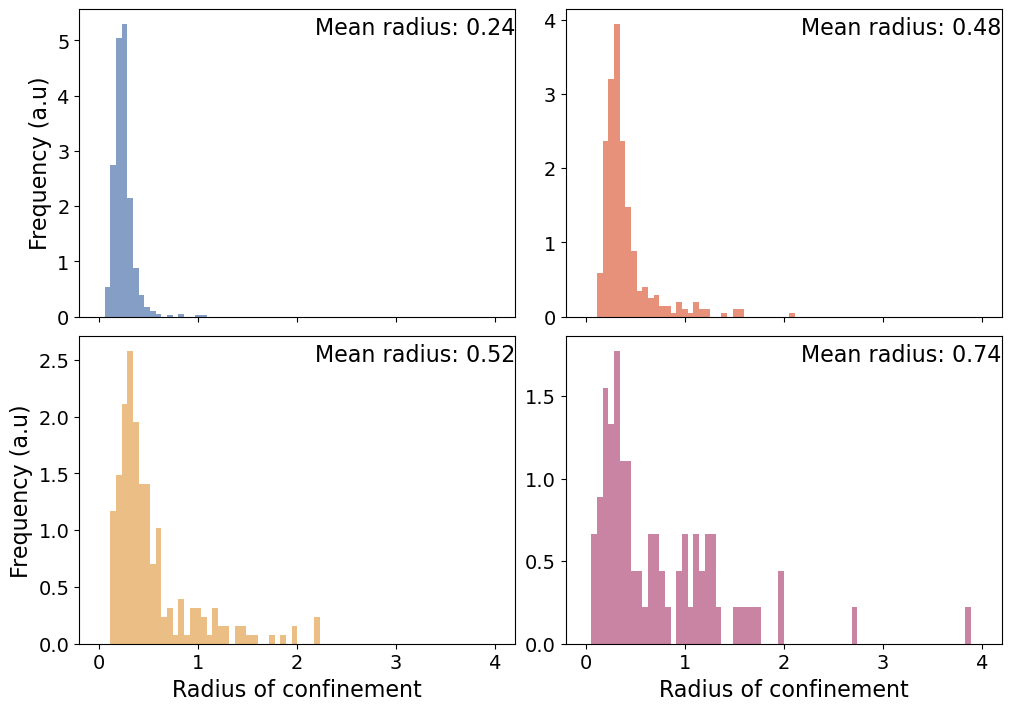

In [ ]:
xlims = [[0, 4], [0, 4]]
fig, axes = plt.subplots(2, 2, figsize=(10, 7), constrained_layout=True)
for i, (ax, xlim) in enumerate(zip(axes.ravel(), 2*xlims)):
    ax.hist(confinement_radius_cl[i], bins=np.linspace(*xlim, 71), density=True, color=colors[i], alpha=0.8)
    # ax.set_xlim(xlim)
    if i >= 2: ax.set_xlabel("Radius of confinement", fontsize=16)
    else:      ax.set_xticklabels([]) 
    if (i % 2) == 0: ax.set_ylabel("Frequency (a.u)", fontsize=16)
    ax.set_title(f"Mean radius: {confinement_radius_cl[i].mean():.2f}", loc='right', y=1, pad=-18, fontsize=16);
    ax.tick_params(labelsize=14)

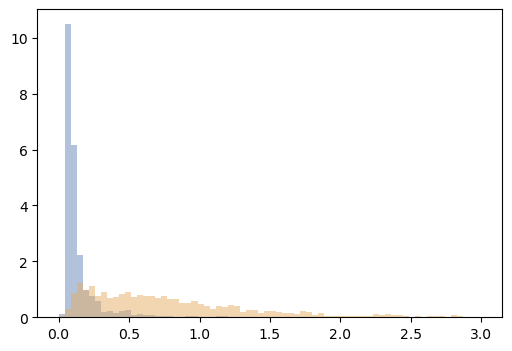

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(confinement_radius_cl[0], bins=np.linspace(0, 3, 71), density=True, color=colors[0], alpha=0.5)
plt.hist(confinement_radius_cl[2], bins=np.linspace(0, 3, 71), density=True, color=colors[2], alpha=0.5);

# Weak ergodicity breaking from random diffusivity

Here, we study trajectories from [this paper](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.5.011021).

## Load the data

We start our analysis by loading the trajectories and their point-wise predictions. The data is in $\mu m$ per frame, acquired at 60Hz.

In [ ]:
correction = np.log10(60)

In [ ]:
data_path = Path('../../../hdd/seg_data/data_carlo/data_prx')
df_web = pd.read_csv(data_path/'preds_prx.csv')
# df_web = pd.read_csv(data_path/'preds_attm_0.30s_0.40g.csv')

In [ ]:
df_immobile = pd.read_csv(data_path/'preds_prx_immobile.csv')
df_immobile['index'] += df_web['index'].max()
df_web = pd.concat([df_web, df_immobile], ignore_index=True)

In this dataframe, the first `index` column corresponds to the trajectory label. Then, we have the 2D coordinates of the trajectories in the `x` and `y` columns, which we have set to start at the origin. Then, we have the diffusion coefficient predictions for the raw trajectories, `pred_D`, and the scaled trajectories by a factor of $10$ and $100$ in columns `pred_D_10x` and `pred_D_100x`, respectively. Finally, we have the prediction of the anomalous exponent $\alpha$ in `pred_alpha`.

Since the column label `index` can be confused with the `DataFrame.index`, we will rename it to `traj_idx`.  

In [ ]:
df_web = df_web.rename(columns={'index': 'traj_idx'})

In [ ]:
df_web.head()

,traj_idx,x,y,pred_D,pred_D_10x,pred_D_100x,pred_alpha
0,1.0,0.00000,0.000000,-3.011214,-0.960087,1.088543,0.641549
1,1.0,-0.00540,0.044280,-3.009658,-0.960985,1.078588,0.647630
2,1.0,0.03375,0.071550,-2.990159,-0.962949,1.081988,0.657790
3,1.0,0.11880,-0.026865,-2.980703,-0.955133,1.077695,0.677791
4,1.0,0.10800,-0.032265,-2.985840,-0.944920,1.086051,0.654682


Let's visualize the $D$ predictions for the three scales to determine which ones to use.

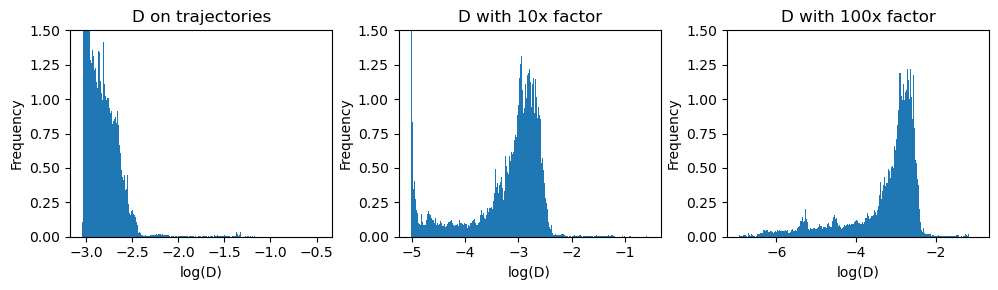

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (10, 3), tight_layout=True)
axs[0].hist(df_web.pred_D, bins=1000, density=True);
axs[0].set_title('D on trajectories')

axs[1].hist(df_web.pred_D_10x - 2, bins=1000, density=True);
axs[1].set_title('D with 10x factor')

axs[2].hist(df_web.pred_D_100x - 4, bins=1000, density=True);
axs[2].set_title('D with 100x factor')

plt.setp(axs, xlabel='log(D)', ylabel='Frequency', ylim=(0, 1.5));

The predictions across the different scales agree very well. It seems that the trajectories scaled by a factor of 100 fit very well in the output range of our model. Therefore, we will work with them.

In [ ]:
correction = -4
df_web['D_tfm'] = df_web.pred_D_100x + correction

Finally, let us have a look at the anomalous exponent distribution.

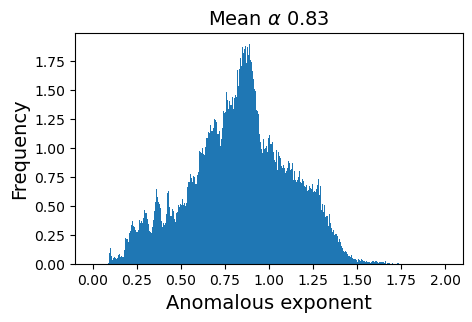

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(df_web.pred_alpha, bins=np.linspace(0,2,1000), density=True)
plt.title(fr'Mean $\alpha$ {df_web.pred_alpha.mean():.2f}', fontsize=14)
plt.xlabel('Anomalous exponent', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

We obtain a mean value of $\alpha=0.83$, which matches very well with the values reported in the original paper of $\alpha=0.84$, obtained with a fitting of the ensemble mean squared displacement, and 0.83, obtained with a fit of the survival function of immobilization events (in the text, the anomalous exponent is $\beta$).

## Trajectory segmentation

Let us now look at the diffusion coefficient predictions to find the different segments of each trajectory.

In [ ]:
def find_segments(pred_d, pred_alpha, traj, pen=1, **kwargs):
    pred = np.stack((pred_d , pred_alpha), axis=-1)
    alg = rpt.KernelCPD(**kwargs).fit(pred_d) # Only changes in D
    # alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    seg_Ds, seg_alphas = [], []
            
    Ds = np.ones_like(pred_d)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        alpha, D = pred_alpha[i:j].mean(), pred_d[i:j].mean()
        Ds[i:j] *= D

        seg_alphas.append(alpha)
        seg_Ds.append(D)

    res_time = cps[1:] - cps[:-1]
    res_time = res_time[1:-1]
    alphas_clean, Ds_clean = seg_alphas[1:-1], seg_Ds[1:-1]
    n_cp = len(cps)-1
    
    return Ds, seg_Ds, seg_alphas, Ds_clean, alphas_clean, res_time, n_cp

In [ ]:
preds, alphas = [], []
seg_ds, seg_alphas, n_cps = [], [], []
seg_ds_clean, seg_alphas_clean, seg_res, seg_vars = [], [], [], []

for idx in tqdm(np.unique(df_web.traj_idx)):
    mask = df_web.traj_idx == idx
    pred_d = df_web.loc[mask, 'D_tfm'].values
    pred_alpha = df_web.loc[mask, 'pred_alpha'].values
    x, y = df_web[mask].x.values, df_web[mask].y.values
    traj = np.array([x-x[0], y-y[0]])

    out = find_segments(pred_d, pred_alpha, traj, min_size=10, pen=0.51)
    Ds, d_seg, a_seg, ds_clean, as_clean, res_time, n_cp = out
    
    df_web.loc[mask, 'D_segment'] = Ds
    seg_ds.append(d_seg)
    seg_alphas.append(a_seg)
    seg_res.append(res_time)
    seg_ds_clean.append(ds_clean)
    seg_alphas_clean.append(as_clean)
    n_cps.append(n_cp)
    preds.append(pred_d)
    alphas.append(pred_alpha)

  0%|          | 0/755 [00:00<?, ?it/s]

In [ ]:
seg_alphas, seg_ds = np.concatenate(seg_alphas), np.concatenate(seg_ds)
seg_alphas_clean = np.concatenate(seg_alphas_clean)
seg_ds_clean = np.concatenate(seg_ds_clean)
seg_res = np.concatenate(seg_res)

## Anomalous exponent from the diffusion coefficient statistics

By looking at both the diffusion diffusion coefficient and the length of the segments, we can extract information about the anomalous exponent.

### D distribution

The theoretical model behind the experiment provides a probability distribution for D of the form $$P(D) = \frac{D^{\sigma - 1}\exp(-D/b)}{b^\sigma\Gamma(\sigma)}\,,$$ with free parameters $\sigma$ and $b$. These parameters will allow us to estimate $\alpha$ by looking at the residence times of the different diffusive states.

Therefore, let us empirically estimate the probability distribution from the predictions and fit a function of the same form. 

In [ ]:
data_d = seg_ds # seg_ds or seg_ds_clean

In [ ]:
counts, edges = np.histogram(data_d, bins=np.linspace(-7, -1, 41), density=True)

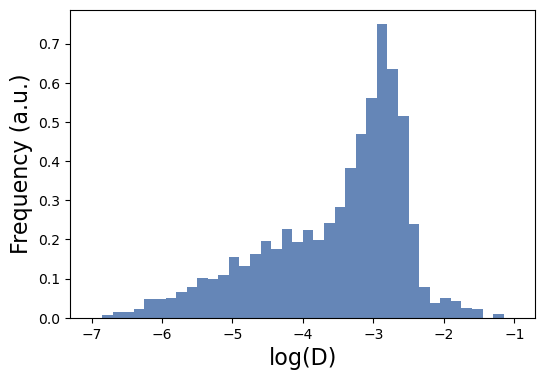

In [ ]:
bin_size = edges[1] - edges[0]
x = edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16);

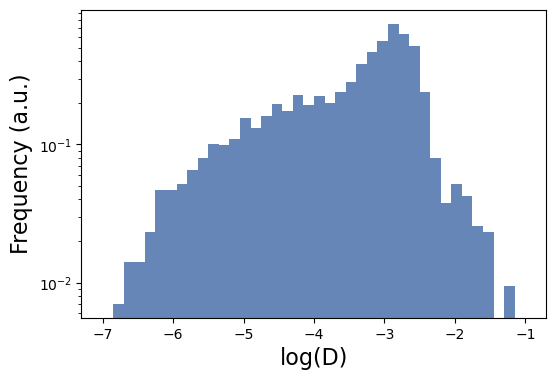

In [ ]:
bin_size = edges[1] - edges[0]
x = edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.yscale('log')
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16);

Since we're estimating the probability density function from a histogram.

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import gamma as gamma_fun

Let's try to fit a line in the power-law regime to find $\sigma$ as we know that for low $D$, the distribution behaves as $\sim D^{\sigma-1}$

In [ ]:
power_law_fit = lambda x, a, b: a*x + b
x_fit = edges[:-1] + np.diff(edges)/2
mask = (-6.1 < x_fit) & (x_fit < -3)
params, _ = curve_fit(power_law_fit, x_fit[mask], np.log10(counts[mask]))

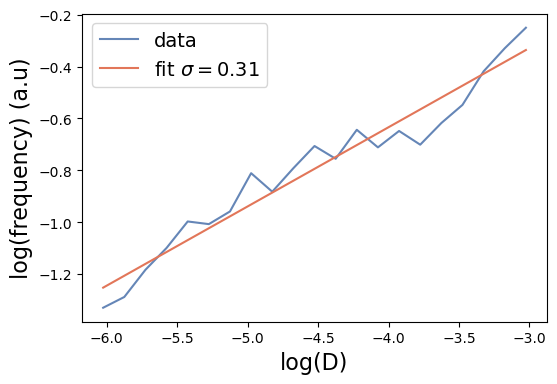

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(x_fit[mask], np.log10(counts[mask]), label="data", color=colors[0])
plt.plot(x_fit[mask], power_law_fit(x_fit[mask], *params),
         label=fr"fit $\sigma=${params[0]:.2f}", color=colors[1])
plt.legend(fontsize=14)
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("log(frequency) (a.u)", fontsize=16);

Or we can also try to fit the gamma distribution

In [ ]:
n_bins = 80
cdf_x, cdf_y = np.sort(10**data_d), np.linspace(0, 1, len(data_d))
interval_edges = np.logspace(-7, -1, n_bins + 1)
x_fit, y_fit = np.zeros(n_bins), np.zeros(n_bins)
for k, (low, high) in enumerate(zip(interval_edges[:-1], interval_edges[1:])):
    x_fit[k] = (low + high)/2
    mask = (cdf_x >= low) & (cdf_x < high)
    idx_true = np.where(mask == True)[0]
    if mask.any(): y_fit[k] = (cdf_y[idx_true[-1]] - cdf_y[idx_true[0]])#/(high - low)

In [ ]:
# def fit(D, sigma, b, a): return a*D**(sigma - 1)*np.exp(-D/b)/(gamma_fun(sigma)*b**sigma)
def fit(D_log, sigma=1.3, b=0.002): return np.log(10)*(10**D_log)*(10**D_log)**(sigma - 1)*np.exp(-(10**D_log)/b)/(gamma_fun(sigma)*b**sigma)


norm = np.trapz(y_fit, np.log10(x_fit))
mask = np.log10(x_fit) > -6
params, _ = curve_fit(fit, np.log10(x_fit[mask]), y_fit[mask]/norm)
sigma = params[0].copy()
print(f'sigma = {params[0]:.3f}\nb = {params[1]:.3f}')#\na = {params[2]}')

sigma = 0.543
b = 0.002


/tmp/ipykernel_179577/3270682058.py:2: RuntimeWarning: invalid value encountered in double_scalars
  def fit(D_log, sigma=1.3, b=0.002): return np.log(10)*(10**D_log)*(10**D_log)**(sigma - 1)*np.exp(-(10**D_log)/b)/(gamma_fun(sigma)*b**sigma)


(0.001, 4.9741110904287575)

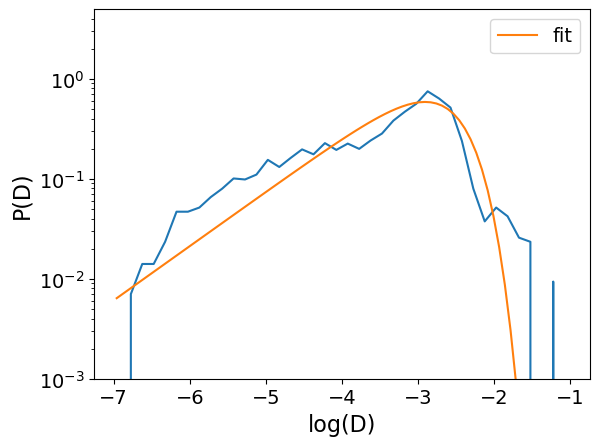

In [ ]:
plt.semilogy(x, counts)
# plt.semilogy(np.log10(x_fit), y_fit/norm, label='data')
plt.semilogy(np.log10(x_fit), fit(np.log10(x_fit), *params), label='fit')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("P(D)", fontsize=16)
plt.ylim(ymin=1e-3)

In [ ]:
power_law_fit = lambda x, a, b: a*x + b
mask = (-6.1 < np.log10(x_fit)) & (np.log10(x_fit) < -4.)
params, _ = curve_fit(power_law_fit, np.log10(x_fit[mask]), np.log10(y_fit[mask]))
print(f'sigma = {params[0]:.3f}\nb = {params[1]:.3f}')#\na = {params[2]}')

sigma = 0.372
b = -0.083


/tmp/ipykernel_179577/4049739429.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(x_fit, np.log10(y_fit), label="data", color=colors[0])


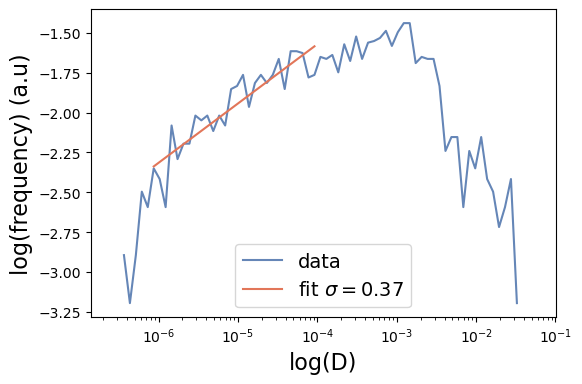

In [ ]:
plt.figure(figsize=(6, 4))
plt.semilogx(x_fit, np.log10(y_fit), label="data", color=colors[0])
plt.semilogx(x_fit[mask], power_law_fit(np.log10(x_fit[mask]), *params),
         label=fr"fit $\sigma=${params[0]:.2f}", color=colors[1])
plt.legend(fontsize=14)
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("log(frequency) (a.u)", fontsize=16);

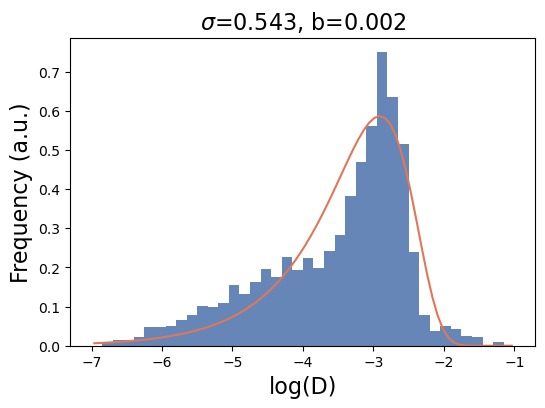

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.plot(np.log10(x_fit), fit(np.log10(x_fit), *params), color=colors[1])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title(fr"$\sigma$={params[0]:.3f}, b={params[1]:.3f}", fontsize=16);

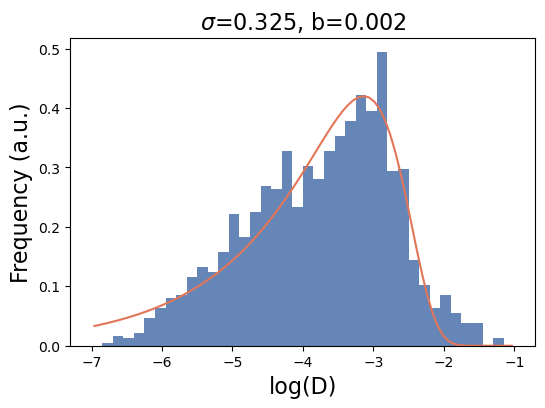

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.plot(np.log10(x_fit), fit(np.log10(x_fit), *params), color=colors[1])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title(fr"$\sigma$={params[0]:.3f}, b={params[1]:.3f}", fontsize=16);

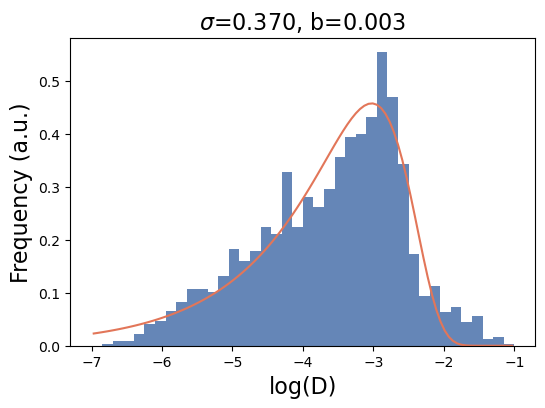

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.plot(np.log10(x_fit), fit(np.log10(x_fit), *params), color=colors[1])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title(fr"$\sigma$={params[0]:.3f}, b={params[1]:.3f}", fontsize=16);

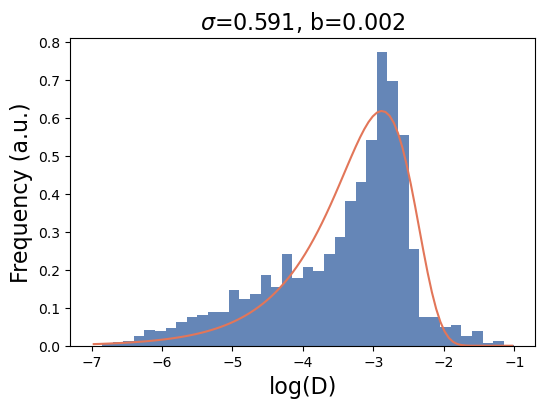

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.plot(np.log10(x_fit), fit(np.log10(x_fit), *params), color=colors[1])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16)
plt.title(fr"$\sigma$={params[0]:.3f}, b={params[1]:.3f}", fontsize=16);

In [ ]:
from scipy.optimize import minimize

In [ ]:
def p_d(D, sigma=0.5, b=0.002): return D**(sigma - 1)*np.exp(-D/b)/(gamma_fun(sigma)*b**sigma)
def p_log(D_log, sigma=0.5, b=0.002): return np.log(10)*(10**D_log)*(10**D_log)**(sigma - 1)*np.exp(-(10**D_log)/b)/(gamma_fun(sigma)*b**sigma)

In [ ]:
def loss_log(p):
    sigma, b = p
    return -np.sum(np.log(p_log(data_d, sigma=sigma, b=b)))

def loss(p):
    sigma, b = p
    return -np.sum(np.log(p_d(10**data_d, sigma=sigma, b=b)))

In [ ]:
bs = np.logspace(-4, -1, 61)
sigs = np.linspace(0.1, 2.5, 41)
losses_log = np.zeros((len(bs), len(sigs)))
losses = np.zeros((len(bs), len(sigs)))

for i, b in enumerate(bs):
    for j, sig in enumerate(sigs):
        losses_log[i, j] = loss_log([sig, b])
        losses[i, j] = loss([sig, b])

/tmp/ipykernel_179577/1535787116.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolor(np.log(losses - losses.min()))


Text(0, 0.5, 'b')

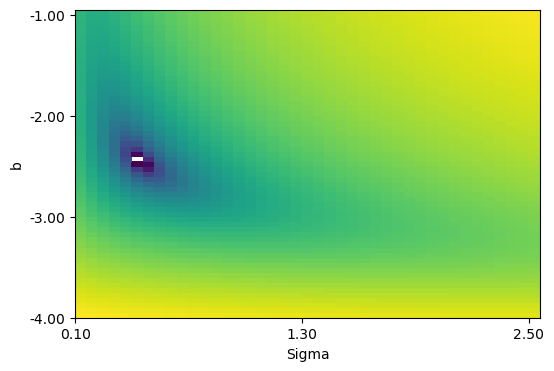

In [ ]:
plt.figure(figsize=(6, 4))
plt.pcolor(np.log(losses - losses.min()))
plt.xticks(np.arange(len(sigs))[::20], [f'{s:.2f}' for s in sigs[::20]])
plt.yticks(np.arange(len(bs))[::20], [f'{np.log10(b):.2f}' for b in bs[::20]])
plt.xlabel("Sigma")
plt.ylabel("b")

Text(0, 0.5, 'log(b)')

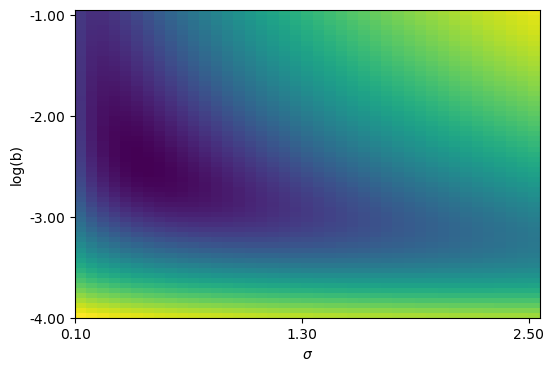

In [ ]:
plt.figure(figsize=(6, 4))
plt.pcolor(np.log(losses_log))
plt.xticks(np.arange(len(sigs))[::20], [f'{s:.2f}' for s in sigs[::20]])
plt.yticks(np.arange(len(bs))[::20], [f'{np.log10(b):.2f}' for b in bs[::20]])
plt.xlabel(r"$\sigma$")
plt.ylabel("log(b)")

In [ ]:
result = minimize(loss, [0.5, 0.03], bounds=((0.1, 2.), (0.0001, 1.)))
result

      fun: -16907.38598667457
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04110916, -4.20004653])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 13
     njev: 19
   status: 0
  success: True
        x: array([0.41866378, 0.00336529])

In [ ]:
result_log = minimize(loss_log, [1., 0.001], bounds=((0.05, 3.), (0.0001, 1.)))
result_log

      fun: 3850.5552922919887
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0003638, -0.0001819])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 99
      nit: 26
     njev: 33
   status: 0
  success: True
        x: array([0.41866437, 0.00336533])

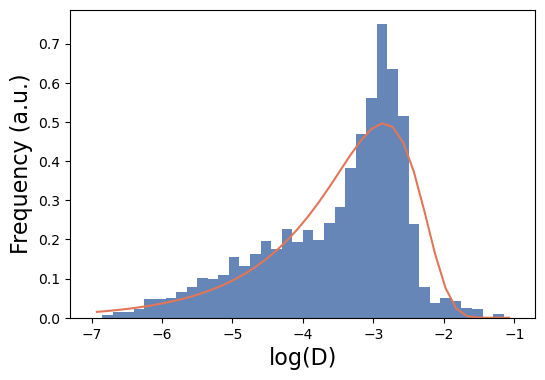

In [ ]:
counts, edges = np.histogram(data_d, bins=np.linspace(-7, -1, 41), density=True)
sigma, b = result.x

bin_size = edges[1] - edges[0]
x = edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.plot(x, p_log(x, sigma=sigma, b=b), color=colors[1])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16);

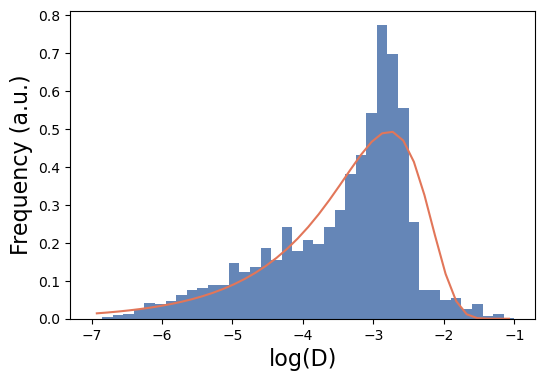

In [ ]:
counts, edges = np.histogram(data_d, bins=np.linspace(-7, -1, 41), density=True)
sigma, b = result.x

bin_size = edges[1] - edges[0]
x = edges[:-1] + bin_size/2
plt.figure(figsize=(6, 4))
plt.bar(x, counts, width=bin_size, color=colors[0])
plt.plot(x, p_log(x, sigma=sigma, b=b), color=colors[1])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16);

In [ ]:
cdf_d = [np.trapz(p_d(10**x[:i+1], sigma=result.x[0], b=result.x[1]), 10**x[:i+1]) for i in range(1, len(x))]
cdf_log = [np.trapz(p_log(x[:i+1], sigma=result.x[0], b=result.x[1]), x[:i+1]) for i in range(1, len(x))]

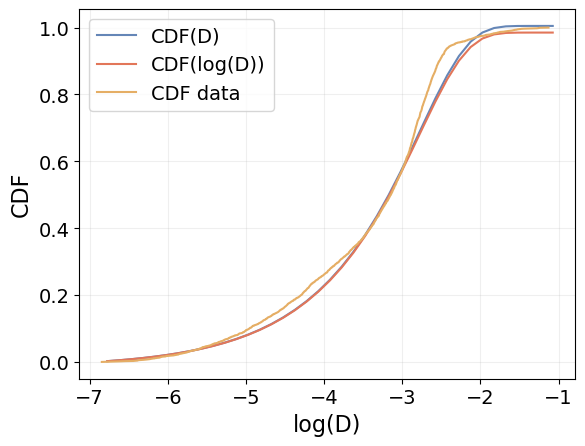

In [ ]:
plt.plot(x[1:], cdf_d, label="CDF(D)", color=colors[0])
plt.plot(x[1:], cdf_log, label="CDF(log(D))", color=colors[1])
plt.plot(np.log10(cdf_x), cdf_y, label="CDF data", color=colors[2])
plt.grid(alpha=alpha_grid)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("CDF", fontsize=16)
plt.xlabel("log(D)", fontsize=16);

In [ ]:
cdf_d = [np.trapz(p_d(10**x[:i+1], sigma=0.591, b=0.002), 10**x[:i+1]) for i in range(1, len(x))]
cdf_log = [np.trapz(p_log(x[:i+1], sigma=0.591, b=0.002), x[:i+1]) for i in range(1, len(x))]

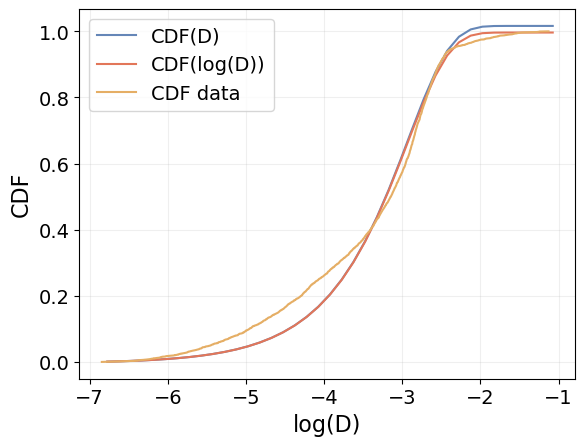

In [ ]:
plt.plot(x[1:], cdf_d, label="CDF(D)", color=colors[0])
plt.plot(x[1:], cdf_log, label="CDF(log(D))", color=colors[1])
plt.plot(np.log10(cdf_x), cdf_y, label="CDF data", color=colors[2])
plt.grid(alpha=alpha_grid)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("CDF", fontsize=16)
plt.xlabel("log(D)", fontsize=16);

### Conditional residence time distribution

In a similar way as $P(D)$, we can also study the conditional distribution of transit times $\tau$, given by $$P_\tau(\tau|D)=\frac{D^\gamma}{k}\exp(-\tau D^\gamma/k)\,,$$ with free parameters $\gamma$ and $k$.

In [ ]:
# Expectation value should be D**gamma -> try!

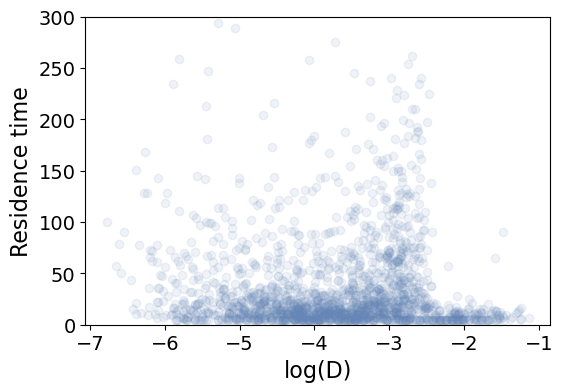

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(seg_ds_clean, seg_res, alpha=0.1, color=colors[0])
plt.ylim([0, 300])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("Residence time", fontsize=16)
plt.tick_params(labelsize=14)

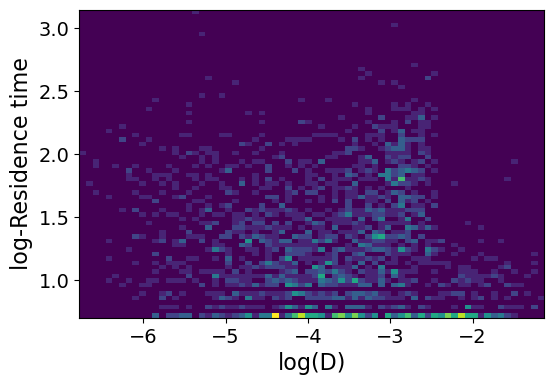

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(seg_ds_clean, np.log10(seg_res), bins=70)
# plt.ylim([0, 300])
plt.xlabel("log(D)", fontsize=16)
plt.ylabel("log-Residence time", fontsize=16)
plt.tick_params(labelsize=14)

In [ ]:
def p_tau_cond(tau, D, gamma, k):
    "Conditional distribution P(tau|D)."
    return D**gamma*np.exp(-tau*D**gamma/k)/k

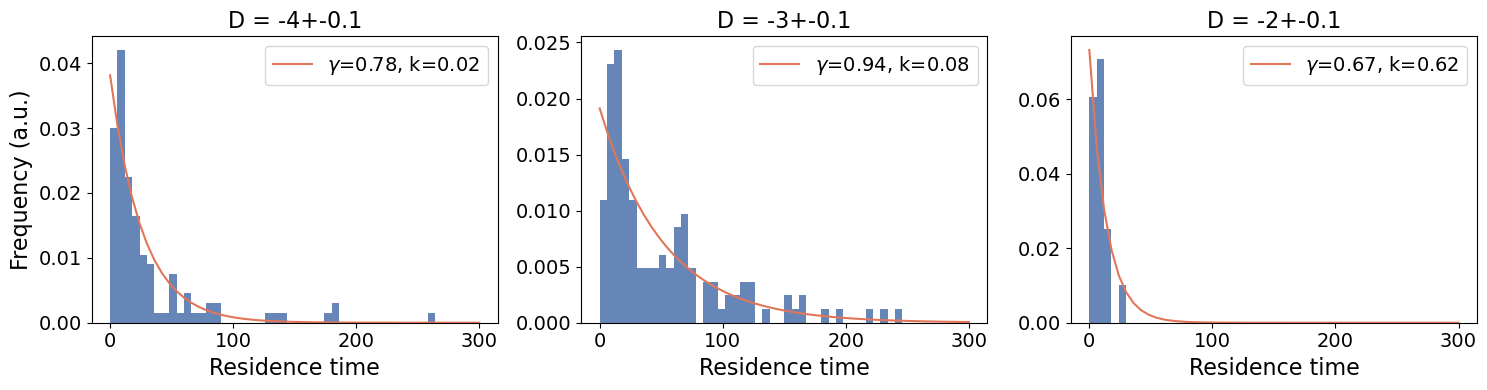

In [ ]:
D_values, dD = [-4, -3, -2], 0.1
intervals = [(D - dD, D + dD) for D in D_values]

fig, axes = plt.subplots(1, len(D_values), figsize=(len(D_values)*5, 4), tight_layout=True)
for D, interval, ax in zip(D_values, intervals, axes):
    low, high = interval
    mask = (seg_ds_clean >= low) & (seg_ds_clean < high) 
    counts, bins, _ = ax.hist(seg_res[mask], bins=np.linspace(0, 300, 51), density=True, color=colors[0])
    fit = lambda tau, gamma, k: p_tau_cond(tau, 10**D, gamma, k)
    params, _ = curve_fit(fit, bins[:-1], counts)
    ax.plot(bins, fit(bins, *params), color=colors[1], label=fr'$\gamma$={params[0]:.2f}, k={params[1]:.2f}')
    ax.set_title(f"D = {D}+-{dD}", fontsize=16)
    ax.set_xlabel("Residence time", fontsize=16)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
axes[0].set_ylabel("Frequency (a.u.)", fontsize=16);

The conditional distribution $P(\tau|D$) is an exponential distribution with expectation value $kD^{-\gamma}$. We can find the parameters $k$ and $\gamma$ by fitting the mean value over the power-law range of $P(D)$.

In [ ]:
D_values, dD = np.arange(-6., -3., 0.05), 0.2
intervals = [(D - dD, D + dD) for D in D_values]
means = []

for D, interval in zip(D_values, intervals):
    low, high = interval
    mask = (seg_ds_clean >= low) & (seg_ds_clean < high)
    means.append(seg_res[mask].mean())

In [ ]:
def tau_mean(D, gamma, k): return k*D**(-gamma)

In [ ]:
params_means, _ = curve_fit(tau_mean, 10**D_values[9:], means[9:])
print(f"gamma = {params_means[0]:.3f}\nk = {params_means[1]:.3f}")

gamma = 0.124
k = 11.118


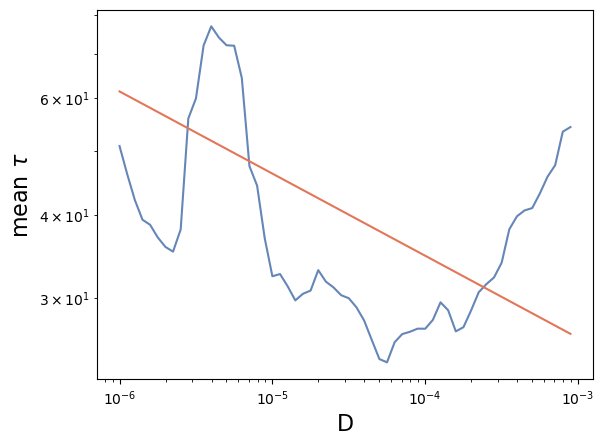

In [ ]:
plt.loglog(10**D_values, means, color=colors[0])
plt.loglog(10**D_values, tau_mean(10**D_values, *params_means), color=colors[1])
plt.xlabel("D", fontsize=16)
plt.ylabel(r"mean $\tau$", fontsize=16);

We can obtain an estimation of $\gamma$ and $k$ by considering the marginal pdf for $\tau$ : $$P(\tau) = \int P(\tau, D)dD=\int P(\tau|D)P(D)dD\,,$$ which we can compute numerically.

In [ ]:
def p_tau_d(tau, D, gamma, k, sigma, b):
    "Joint probability distribution P(tau, D)=P(tau|D)P(D)."
    return p_tau_cond(tau, D, gamma, k)*p_d(D, sigma=sigma, b=b)
    
def p_tau(tau, gamma, k, sigma, b):
    "Marginal probability distribution P(tau)=\int P(tau|D)P(D)dD."
    Ds = np.logspace(-7, 0, 101)
    return np.trapz(p_tau_d(tau, Ds, gamma, k, sigma, b), Ds)

p_tau = np.vectorize(p_tau)

In [ ]:
from scipy.optimize import minimize

In [ ]:
def loss_tau(p):
    gamma, k = p
    return -np.sum(np.log(p_tau(seg_res[seg_res > 5], gamma, k, sigma=0.37, b=0.0026)))

def loss_tau_d(p):
    gamma, k = p
    mask = seg_res > 5
    return -np.sum(np.log(p_tau_d(seg_res[mask], 10**seg_ds_clean[mask],
                                  gamma, k, sigma=0.37, b=0.0052)))

In [ ]:
ks = np.logspace(-2, 2, 21)
gammas = np.linspace(0.05, 1., 20)
losses_marginal = np.zeros((len(ks), len(gammas)))
losses_joint = np.zeros((len(ks), len(gammas)))

for i, k in tqdm(enumerate(ks)):
    for j, g in enumerate(gammas):
        losses_marginal[i, j] = loss_tau([g, k])
        losses_joint[i, j] = loss_tau_d([g, k])

0it [00:00, ?it/s]

/tmp/ipykernel_2815988/1486340518.py:3: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(p_tau(seg_res[seg_res > 5], gamma, k, sigma=0.37, b=0.0026)))
/tmp/ipykernel_2815988/1486340518.py:8: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(p_tau_d(seg_res[mask], 10**seg_ds_clean[mask],


/tmp/ipykernel_2815988/1743360530.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolor(np.log(losses_marginal - losses_marginal.min()))


Text(0, 0.5, 'k')

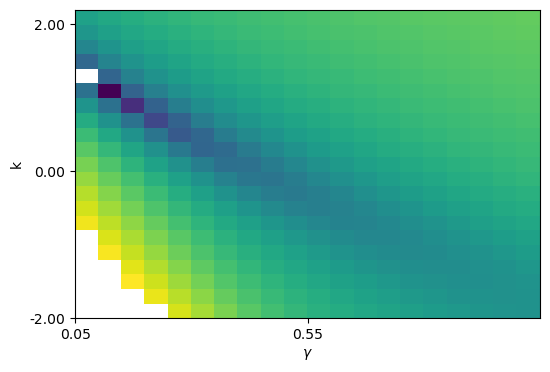

In [ ]:
plt.figure(figsize=(6, 4))
plt.pcolor(np.log(losses_marginal - losses_marginal.min()))
plt.xticks(np.arange(len(gammas))[::10], [f'{g:.2f}' for g in gammas[::10]])
plt.yticks(np.arange(len(ks))[::10], [f'{np.log10(k):.2f}' for k in ks[::10]])
plt.xlabel(r"$\gamma$")
plt.ylabel("k")

/tmp/ipykernel_2815988/1980120256.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolor(np.log(losses_joint - losses_joint.min()))


Text(0, 0.5, 'k')

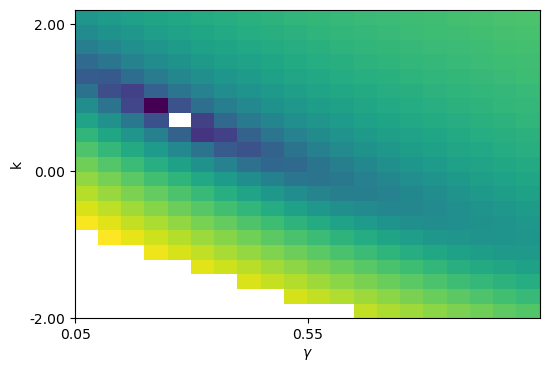

In [ ]:
plt.figure(figsize=(6, 4))
plt.pcolor(np.log(losses_joint - losses_joint.min()))
plt.xticks(np.arange(len(gammas))[::10], [f'{g:.2f}' for g in gammas[::10]])
plt.yticks(np.arange(len(ks))[::10], [f'{np.log10(k):.2f}' for k in ks[::10]])
plt.xlabel(r"$\gamma$")
plt.ylabel("k")

In [ ]:
result = minimize(loss_tau_d, [0.5, 1.])
result

/tmp/ipykernel_2815988/1486340518.py:8: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(p_tau_d(seg_res[mask], 10**seg_ds_clean[mask],
/home/brequena/anaconda3/envs/andi/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_2815988/1486340518.py:8: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(p_tau_d(seg_res[mask], 10**seg_ds_clean[mask],


      fun: 20599.07625757328
 hess_inv: array([[ 4.58708227e-06, -4.40854819e-09],
       [-4.40854819e-09,  9.97533789e-09]])
      jac: array([0.00048828, 0.00024414])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 76
      nit: 17
     njev: 24
   status: 2
  success: False
        x: array([0.2336011 , 4.58321755])

In [ ]:
tau_values, tau_counts = np.unique(seg_res, return_counts=True)
tau_counts = tau_counts/tau_counts.sum()

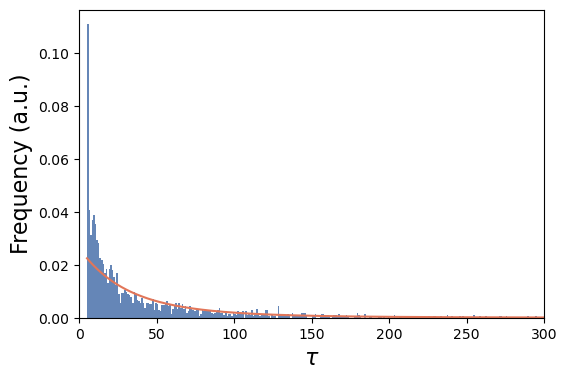

In [ ]:
x = tau_values + 0.5
plt.figure(figsize=(6, 4))
plt.bar(x, tau_counts, width=1., color=colors[0])
plt.plot(tau_values, p_tau(tau_values, result.x[0], result.x[1], sigma=0.337, b=0.0052), color=colors[1])
# plt.plot(x, p_tau(x, 0.4, 0.7, sigma=0.337, b=0.0052), color=colors[1])
plt.xlim([0, 300])
plt.xlabel(r"$\tau$", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16);

In [ ]:
from functools import partial
from scipy.optimize import curve_fit

In [ ]:
cdf_x, cdf_y = tau_values, np.cumsum(tau_counts)
dx = np.diff(cdf_x)
x_fit, y_fit = cdf_x[:-1], np.diff(cdf_y)/dx

In [ ]:
fit = lambda x, gamma, k: p_tau(x, gamma, k, sigma=0.337, b=0.0052)

In [ ]:
tau_params, _ = curve_fit(fit, x_fit, y_fit)
print(f"gamma = {tau_params[0]:.3f}\nk = {tau_params[1]:.3f}")

gamma = 0.274
k = 2.356


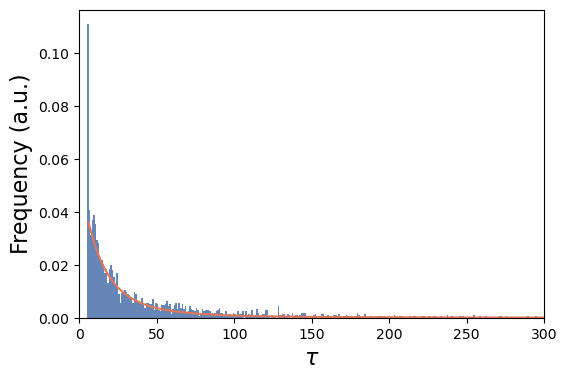

In [ ]:
x = tau_values + 0.5
xx = np.arange(6, 300)
plt.figure(figsize=(6, 4))
plt.bar(x, tau_counts, width=1., color=colors[0])
plt.plot(xx, fit(xx, *tau_params), color=colors[1])
plt.xlim([0, 300])
plt.xlabel(r"$\tau$", fontsize=16)
plt.ylabel("Frequency (a.u.)", fontsize=16);

[<matplotlib.lines.Line2D>]

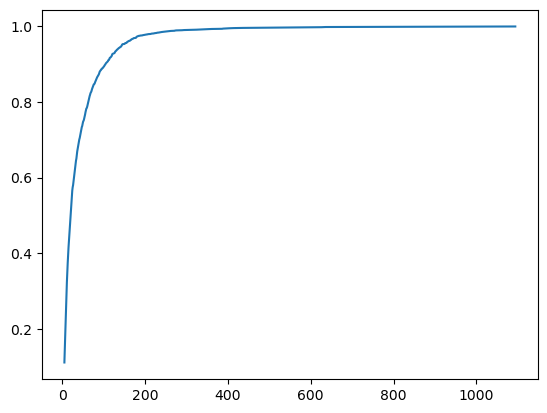

In [ ]:
plt.plot(cdf_x, cdf_y)

### Residence time distribution

We expect the residence times to follow a power-law distribution on their own such that $P(\tau)\sim t^{-(\alpha+1)}$, where $\alpha$ is the anomalous exponent. Let's see whether we find anything similar in our data. 

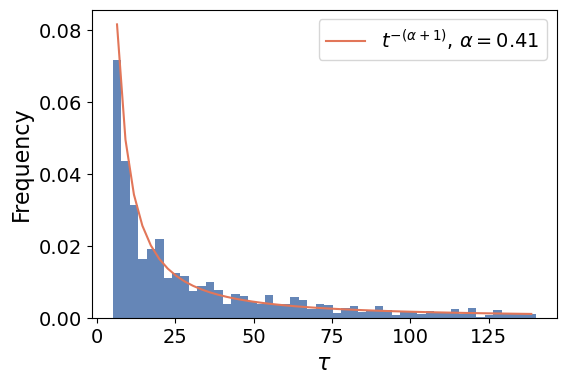

In [ ]:
plt.figure(figsize=(6, 4))
counts, bins, _ = plt.hist(seg_res, bins=np.linspace(5, 140, 51), density=True, color=colors[0])
dx = bins[1] - bins[0]
xx = bins[:-1] + dx/2
fit = np.polyfit(np.log(xx), np.log(counts), deg=1)
plt.plot(xx, np.exp(fit[1])*xx**fit[0], color=colors[1],
         label=fr"$t^{{-(\alpha+1)}}$, $\alpha={{{-fit[0]-1:.2f}}}$")
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\tau$', fontsize=16)
plt.ylabel("Frequency", fontsize=16);

In [ ]:
def power_law_fit(x, alpha, a): return a*x**(-(alpha + 1))

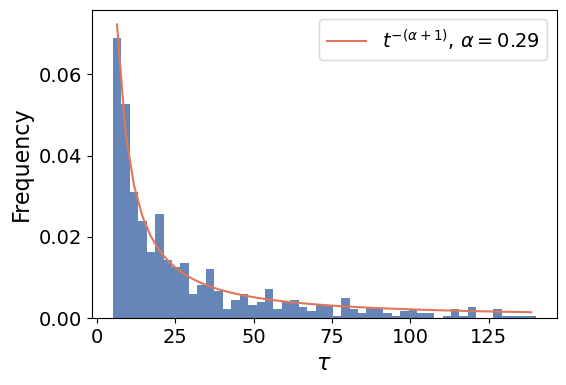

In [ ]:
mask = seg_ds_clean < -4
plt.figure(figsize=(6, 4))
counts, bins, _ = plt.hist(seg_res[mask], bins=np.linspace(5, 140, 51), density=True, color=colors[0])
dx = bins[1] - bins[0]
xx = bins[:-1] + dx/2
params, _ = curve_fit(power_law_fit, xx, counts)

plt.plot(xx, power_law_fit(xx, *params), color=colors[1],
         label=fr"$t^{{-(\alpha+1)}}$, $\alpha={{{params[0]:.2f}}}$")
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\tau$', fontsize=16)
plt.ylabel("Frequency", fontsize=16);

This way, we obtain an anomalous exponent that is about half what it should be.

### Ageing?

In [ ]:
preds = [];
for traj_idx in tqdm(np.unique(df[0].values)):
    pred_d = df.loc[df[0] == traj_idx][5].values
    pred_d /= pred_d[0]
    preds.append(pred_d[:182])
preds=np.array(preds)

### 2D histrograms

In [ ]:
plt.hist2d(df[5].values-2, df[6].values, bins = [np.linspace(-4,-2.3,50), np.linspace(0.5,1.5,50)], density = True, cmap = plt.cm.OrRd);
plt.xlabel('Diffusion coefficient')
plt.ylabel('Anomalous exponent')

In [ ]:
regions = [[-3.05, -2.93, 1.23, 1.4],
           [-3.1, -2.97, 0.95, 1.07],
           [-2.98, -2.9, 0.8, 0.9],
           [-2.7, -2.6, 1.12, 1.3],
           [-2.7, -2.55, 0.95, 1.1]]

In [ ]:
import matplotlib.patches as patches
fig, ax = plt.subplots()

ax.hist2d(df[5].values-2, df[6].values, bins = [np.linspace(-4,-2.3,50), np.linspace(0.5,1.5,50)], density = True);

for region in regions:
    rect = patches.Rectangle((region[0], region[2]), region[1]-region[0], region[3]-region[2], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [ ]:
region_oc = np.zeros((len(regions), len(df[0].unique())))
for idx, unic in enumerate(df[0].unique()):
    pred_d = df.loc[df[0] == unic][5].values-2
    as_pred = df.loc[df[0] == unic][6].values
    
    for idxr, region in enumerate(regions):
        num_in = np.argwhere((pred_d > region[0]) & (pred_d < region[1]) & (as_pred > region[2]) & (as_pred < region[3]))
        region_oc[idxr, idx] = len(num_in)
    

In [ ]:
fig, axs = plt.subplots(len(regions), 1)
for ax, val in zip(axs, region_oc):
    ax.plot(val)

In [ ]:
df[0].unique().shape

In [ ]:
fig, axs = plt.subplots(10, 5, figsize = (5*3, 10*3))
for idx, ax in zip(df[0].unique(), axs.flatten()):
    pred_d = df.loc[df[0] == idx][5].values-2
    as_pred = df.loc[df[0] == idx][6].values
    
    ax.hist2d(pred_d, as_pred, bins = [np.linspace(-5,-1.5,100), np.linspace(0.3,1.6,50)])
plt.setp(axs[:,1:], yticklabels = [])
plt.setp(axs[:-1,:], xticklabels = []);

In [ ]:
import matplotlib


cmap = plt.cm.get_cmap('tab10', 10)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

In [ ]:
preds = [];
for traj_idx in tqdm(np.unique(df[0].values)):
    pred_d = df.loc[df[0] == traj_idx][5].values
    preds.append(pred_d)

In [ ]:
fig, axs = plt.subplots(10,5 , figsize = (5*3, 10*1.5), tight_layout = True)
for p, ax in zip(preds, axs.flatten()):
    seg_fit_D, _ ,_ = fit_segments_numpy(np.array(p), pen=0.1, min_size=5)
    ax.plot(p-2, alpha = 0.6)
    ax.plot(seg_fit_D-2)
plt.setp(axs, ylim = (-4.8, -2.3));
# plt.setp(axs[:,1:], yticklabels = []);
plt.setp(axs[:, :2], ylabel = 'log(D)' );
# plt.setp(axs[:-1,:], yticklabels = []);

### Exponents from fitting segments of D

In [ ]:
from andi_datasets.analysis import msd_analysis

In [ ]:
Ds, alphas, alphas_fit = [], [], []
for traj_idx in tqdm(np.unique(df[0].values)):
    pred = df.loc[df[0] == traj_idx][5].values
    preda = df.loc[df[0] == traj_idx][6].values
    x = df.loc[df[0] == traj_idx][2].values
    y = df.loc[df[0] == traj_idx][3].values
    
    alg = rpt.KernelCPD(min_size=5).fit(pred)
    
    cps = np.array(alg.predict(pen=1))[:-1]
    if len(cps) > 0:
        seg_fit = np.ones(cps[-1])
        
        for i, j in zip(cps[:-1], cps[1:]):
                        
            alpha_seg = np.mean([msd_analysis().get_exponent(x[i:j]),
                                 msd_analysis().get_exponent(y[i:j])])            
            
            Ds.append(pred[i:j].mean())
            alphas.append(preda[i:j].mean())
            alphas_fit.append(alpha_seg)

In [ ]:
plt.hist(df[5].values, bins = np.linspace(-3.2,1,1000), density = True, label = r'All $D$');
plt.hist(Ds, bins = np.linspace(-3.2,1,100), density = True, label = 'Mean segments', alpha = 0.5);
# plt.axvline(-1.3, c = 'k', ls = '--', alpha = 1, label = 'Proposed change low states')
plt.xlabel('Diffusion Coefficient')
plt.ylabel('Frequency')
plt.ylim(ymax = 2)
plt.legend()

In [ ]:
len(alphas_fit)

In [ ]:
plt.hist(df[6].values, bins = np.linspace(0,2,1000), density = True);
plt.hist(alphas, bins = np.linspace(0,2,100), density = True, alpha = 0.5, label = r'Mean $\alpha$ in D-segments');
plt.hist(alphas_fit, bins = np.linspace(0,2,1000), density = True, alpha = 0.5, label = 'Fitting MSD from D-segments');
plt.legend()

plt.xlabel('Anomalous exponent')
plt.ylabel('Frequency')

In [ ]:
def extract_info(df, d_sep = -1.3):
    preds = []; trajs = []; angles = []
    ds, res, lens, varss, angs = [], [], [], [], []
    ang_low = []
    ang_hi = []
    for traj_idx in tqdm(np.unique(df[7].values)):
        pred_d = df.loc[df[7] == traj_idx][11].values
        x = df.loc[df[7] == traj_idx][0].values
        y = df.loc[df[7] == traj_idx][1].values
        preds.append(pred_d)
        trajs.append(np.array([x-x[0], y-y[0]]))

        pred = preds[-1]
        traj = trajs[-1]

        se, r, d, _ , ang, var = fit_segments_parameters(pred, traj, pen=0.1, min_size=5)
        ds = np.concatenate((ds, d))
        res = np.concatenate((res, r)) 
        varss = np.concatenate((varss, var))    
        angs = angs + ang



        for d, a  in zip(d, ang):
            if d < d_sep:
                ang_low = ang_low + a        
            elif d > d_sep:
                ang_hi = ang_hi + a

    # There are some strange trajectories which lead to wrong values
    ang_low, ang_hi = np.array(ang_low), np.array(ang_hi)
    for val in [0, 90, 180, 270]:
        ang_hi = ang_hi[ang_hi != val]
        ang_low = ang_low[ang_low != val]
        
    return ang_hi, ang_low, varss, res, preds, trajs, ds

In [ ]:
ang_hi, ang_low, varss, res, preds, trajs, ds = extract_info(df, d_sep = -2)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.hist(2*np.pi*np.array(ang_hi)/360, bins = 100, density = 1, label = 'Fast')
ax.hist(2*np.pi*np.array(ang_low)/360, bins = 100, density = 1, alpha = 0.5, label = 'Slow');
ax.legend()
plt.setp(ax, yticklabels = []);
# ax[0].set_title(fr'$\log(D) > {d_sep}$')
# ax[1].set_title(fr'$\log(D) < {d_sep}$')

### Survival

In [ ]:
ds, res, lens, varss, angs = [], [], [], [], []
for pred, traj in zip(tqdm(preds), trajs):
    se, r, d, _ , ang, var = fit_segments_parameters(pred, traj, pen=0.1, min_size=5)
    ds = np.concatenate((ds, d))
    res = np.concatenate((res, r)) 
    varss = np.concatenate((varss, var))    
    angs = angs + ang
    
    lens.append(len(se))
    
times = np.arange(5, 200)
survival = np.zeros((2, len(times))).astype(float)
for idx, t in enumerate((times)):    
    survival[0, idx] = len(res[np.argwhere((res > t) & (ds < -2))])/len(res)
    survival[1, idx] = len(res[np.argwhere((res > t) & (ds > -2))])/len(res)

In [ ]:
labels = [r'$D < 10^{-1.3}$', r'$D > 10^{-1.3}$']

for i, label in enumerate(labels):
    plt.plot(times, survival[i]/survival[i].sum(), 'o', label = label)
plt.ylabel(r'$P(t>\tau)$', fontsize = 14)
plt.xlabel(r'$\tau$', fontsize = 14)
plt.yscale('log')
plt.legend()

In [ ]:
df.head()

# Figure paper

## WT

In [ ]:
df_wt = pd.read_csv('data/inference_WT_noise.csv', header = None)
Ds_wt = df_wt[13].values
Ds_wt[Ds_wt < -2] = df_wt.loc[df_wt[13].values < -2][14]-2
alphas_wt = df_wt[15].values

In [ ]:
plt.hist(Ds_wt, bins = np.linspace(-5,0.5,1000) , density = True);
plt.xlabel('log(D)')
plt.ylabel('Frequency')

In [ ]:
d_sep = -2
preds = []; trajs = []; angles = []
ds, res, lens, varss, angs = [], [], [], [], []
ang_low = []
ang_hi = []
for traj_idx in tqdm(np.unique(df_wt[12].values)):
    pred_d = df_wt.loc[df_wt[12] == traj_idx][13].values
    x = df_wt.loc[df_wt[12] == traj_idx][0].values
    y = df_wt.loc[df_wt[12] == traj_idx][1].values
    preds.append(pred_d)
    trajs.append(np.array([x-x[0], y-y[0]]))

    pred = preds[-1]
    traj = trajs[-1]

    se, r, d, _ , ang, var = fit_segments_parameters(pred, traj, pen=0.1, min_size=5)
    ds = np.concatenate((ds, d))
    res = np.concatenate((res, r)) 
    varss = np.concatenate((varss, var))    
    angs = angs + ang



    for d1, a1  in zip(d, ang):
        if d1 < d_sep:
            ang_low = ang_low + a1        
        elif d1 > d_sep:
            ang_hi = ang_hi + a1

# There are some strange trajectories which lead to wrong values
ang_low, ang_hi = np.array(ang_low), np.array(ang_hi)
for val in [0, 90, 180, 270]:
    ang_hi = ang_hi[ang_hi != val]
    ang_low = ang_low[ang_low != val]
    
# Survival time
times = np.arange(5, 200)
survival = np.zeros((2, len(times))).astype(float)
for idx, t in enumerate((times)):    
    survival[0, idx] = len(res[np.argwhere((res > t) & (ds > -2))])/len(res)
    survival[1, idx] = len(res[np.argwhere((res > t) & (ds < -2))])/len(res)

In [ ]:
labels = [r'$D > 10^{-1.3}$', r'$D < 10^{-1.3}$']

for i, label in enumerate(labels):
    plt.plot(times, survival[i]/survival[i].sum(), '-', label = label, lw = 3)
plt.ylabel(r'$P(t>\tau)$', fontsize = 14)
plt.xlabel(r'$\tau$', fontsize = 14)
plt.yscale('log')
# plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize = (5*2, 4*2), tight_layout = True)
binsD = np.linspace(-2.5,0.5,1000)

# Distribution D
ax_D = plt.subplot(221)
ax_D.hist(Ds_wt, bins = binsD, density = True);
ax_D.axvline(d_sep, ls = '--', c = 'k', alpha = 0.2, zorder = -1)
plt.setp(ax_D, xlabel ='Diffusion Coefficient', ylabel = 'Frequency')

# 2D histogram
ax_hist = plt.subplot(223)
ax_hist.hist2d(Ds_wt, alphas_wt, bins = [np.linspace(binsD.min(), binsD.max(),50), np.linspace(0,2,50)], density = True);
plt.setp(ax_hist, xlabel = 'Diffusion coefficient', ylabel = 'Anomalous exponent')

# Angles
ax_ang = plt.subplot(222, projection='polar')
ax_ang.hist(2*np.pi*np.array(ang_hi)/360, bins = 100, density = 1, label = 'Fast')
ax_ang.hist(2*np.pi*np.array(ang_low)/360, bins = 100, density = 1, alpha = 0.5, label = 'Slow');
ax_ang.legend()
plt.setp(ax_ang, yticklabels = []);

# Survival time
ax_sur = plt.subplot(224)
for sur in survival:
    ax_sur.plot(times, sur/sur.sum())
plt.setp(ax_sur, ylabel = r'$P(t>\tau)$', 
         xlabel = r'$\tau$',
         yscale = 'log');

In [ ]:
fig, ax = plt.subplots(figsize = (5*2, 4*2), tight_layout = True)
binsD = np.linspace(-2.5,0.5,1000)

# Distribution D
ax_D = plt.subplot(221)
ax_D.hist(Ds_wt, bins = binsD, density = True);
ax_D.axvline(d_sep, ls = '--', c = 'k', alpha = 0.2, zorder = -1)
plt.setp(ax_D, xlabel ='Diffusion Coefficient', ylabel = 'Frequency')

# 2D histogram
ax_hist = plt.subplot(223)
ax_hist.hist2d(Ds_wt, alphas_wt, bins = [np.linspace(binsD.min(), binsD.max(),50), np.linspace(0,2,50)], density = True);
plt.setp(ax_hist, xlabel = 'Diffusion coefficient', ylabel = 'Anomalous exponent')

# Angles
ax_ang = plt.subplot(222, projection='polar')
ax_ang.hist(2*np.pi*np.array(ang_hi)/360, bins = 100, density = 1, label = 'Fast')
ax_ang.hist(2*np.pi*np.array(ang_low)/360, bins = 100, density = 1, alpha = 0.5, label = 'Slow');
ax_ang.legend()
plt.setp(ax_ang, yticklabels = []);

# Survival time
ax_sur = plt.subplot(224)
for sur in survival:
    ax_sur.plot(times, sur/sur.sum())
plt.setp(ax_sur, ylabel = r'$P(t>\tau)$', 
         xlabel = r'$\tau$',
         yscale = 'log');

In [ ]:
survival.shape

In [ ]:
np.savetxt('survival_slow.txt', survival[0,:], delimiter = ';')
np.savetxt('survival_fast.txt', survival[1,:], delimiter = ';')